In [1]:
library(readxl)
library(gsheet)
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(car, quietly = TRUE)
library(GGally)
library(gsheet)
library(gridExtra)
library(leaps)
library(glmnet)
library(mltools)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-6


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na




In [2]:
# set seed for notebook
set.seed(7777)

# How Spotify Song Attributes Affect Valence

## Introduction


Starting from infancy and all throughout one's life, listening to music is an activity that the majority of people engage in. Music has been shown to have effects on our daily functioning and overall well-being (Groarke & Hogan, 2018). In particular, how positive or how negative a song sounds plays a critical role in determining how someone will be affected by listening to it. For example, listening to positive sounding music increases self-confidence (Tajadura-Jiménez, 2011) and can help relieve pain (Roy, Peretz, & Rainville, 2008). This musical positiveness present in a song is referred to as its valence, so a song that sounds cheerful and upbeat is said to have high valence (close to 1 in our case). 

Music today is becoming more and more accessible as people can choose what they listen to on the radio, youtube, or on one of the many available streaming services. Currently, Spotify is the world’s most popular music streaming service with over 365 million monthly users (2021). We will be using a dataset containing 232725 songs available on Spotify that contains information about each song such as its genre, danceability, loudness, acousticness, and valence (among others). Our goals are to predict the valence of a song from its other attributes and determine what qualities of a song impact our emotional perception. Therefore, our project will focus on both inference and prediction. First, we will determine which features of the song are most related to its valence, and using these features as our explanatory variables, we will try to build a model to predict a song’s valence.





## Methods & Results

### Preliminary Data Analysis

In [3]:
# Read in the data and drop any na values in the dataset.
df <- gsheet2tbl('https://docs.google.com/spreadsheets/d/1fnNjFKFZmGgavOYezz-swtQICqWyAMMZxs2H6Nsk29M/edit#gid=2110346216')
df = drop_na(df)
print("Table 1: Spotify Dataset")
head(df)


[1] "Table 1: Spotify Dataset"


genre artist_name       track_name                      
1 Movie Henri Salvador    C'est beau de faire un Show     
2 Movie Martin & les fées Perdu d'avance (par Gad Elmaleh)
3 Movie Joseph Williams   Don't Let Me Be Lonely Tonight  
4 Movie Henri Salvador    Dis-moi Monsieur Gordon Cooper  
5 Movie Fabien Nataf      Ouverture                       
6 Movie Henri Salvador    Le petit souper aux chandelles  
  track_id               popularity acousticness danceability duration_ms
1 0BRjO6ga9RKCKjfDqeFgWV 0          0.611        0.389         99373     
2 0BjC1NfoEOOusryehmNudP 1          0.246        0.590        137373     
3 0CoSDzoNIKCRs124s9uTVy 3          0.952        0.663        170267     
4 0Gc6TVm52BwZD07Ki6tIvf 0          0.703        0.240        152427     
5 0IuslXpMROHdEPvSl1fTQK 4          0.950        0.331         82625     
6 0Mf1jKa8eNAf1a4PwTbizj 0          0.749        0.578        160627     
  energy instrumentalness key liveness loudness mode  speechiness tempo  
1 0.9100 0.000            C#  0.3460    -1.828  Major 0.0525      166.969
2 0.7370 0.000            F#  0.1510    -5.559  Minor 0.0868      174.003
3 0.1310 0.000            C   0.1030   -13.879  Minor 0.0362       99.488
4 0.3260 0.000            C#  0.0985   -12.178  Major 0.0395      171.758
5 0.2250 0.123            F   0.2020   -21.150  Major 0.0456      140.576
6 0.0948 0.000            C#  0.1070   -14.970  Major 0.1430       87.479
  time_signature valence
1 4/4            0.814  
2 4/4            0.816  
3 5/4            0.368  
4 4/4            0.227  
5 4/4            0.390  
6 4/4            0.358

In [4]:
# Select relevant features from the dataset, removing metadata such as artist_name, track_name etc.
spotify = df %>% select(-artist_name,  -track_name, -track_id, -duration_ms)
print("Table 2: Spotify Dataset without metadata")
head(spotify)

[1] "Table 2: Spotify Dataset without metadata"


genre popularity acousticness danceability energy instrumentalness key
1 Movie 0          0.611        0.389        0.9100 0.000            C# 
2 Movie 1          0.246        0.590        0.7370 0.000            F# 
3 Movie 3          0.952        0.663        0.1310 0.000            C  
4 Movie 0          0.703        0.240        0.3260 0.000            C# 
5 Movie 4          0.950        0.331        0.2250 0.123            F  
6 Movie 0          0.749        0.578        0.0948 0.000            C# 
  liveness loudness mode  speechiness tempo   time_signature valence
1 0.3460    -1.828  Major 0.0525      166.969 4/4            0.814  
2 0.1510    -5.559  Minor 0.0868      174.003 4/4            0.816  
3 0.1030   -13.879  Minor 0.0362       99.488 5/4            0.368  
4 0.0985   -12.178  Major 0.0395      171.758 4/4            0.227  
5 0.2020   -21.150  Major 0.0456      140.576 4/4            0.390  
6 0.1070   -14.970  Major 0.1430       87.479 4/4            0.358

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Children’s Music' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Children’s Music' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Children’s Music' in 'mbcsToSbcs': dot substituted for <99>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Children’s Music' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Children’s Music' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Children’s Music' in 'mbcsToSbcs': dot substituted for <99>

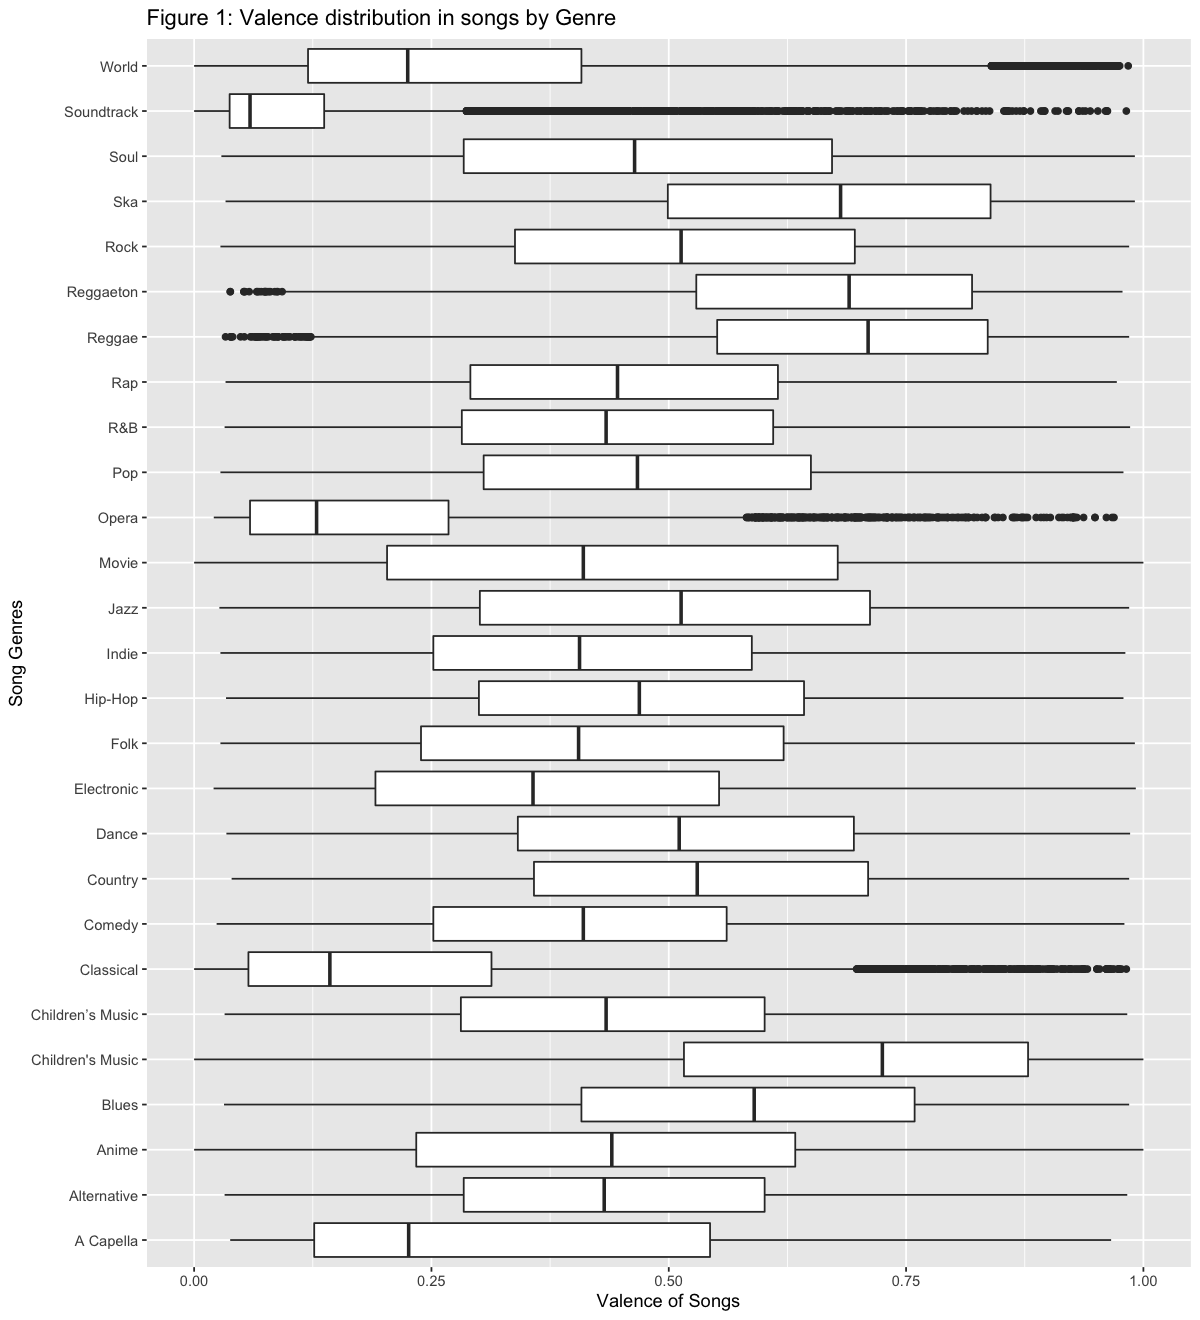

In [5]:
# Visualise the distribution of valence across all genres
# Note that the response variable is on the x-axis, this was done because due to the amount of different genres, having genre on the x axis
# made the labels difficult to read, even with rotated text.
options(repr.plot.width = 10, repr.plot.height = 11)
genre_plot = df %>%
ggplot() +
geom_boxplot(aes(y = genre, x = valence)) + 
labs(x = "Valence of Songs", y = "Song Genres", title = "Figure 1: Valence distribution in songs by Genre")

genre_plot



We have a wide variety of distributions for valence over different levels of genre, so it might be worthwhile to explore how the relationship between our predictive variables and the response is affected by genre

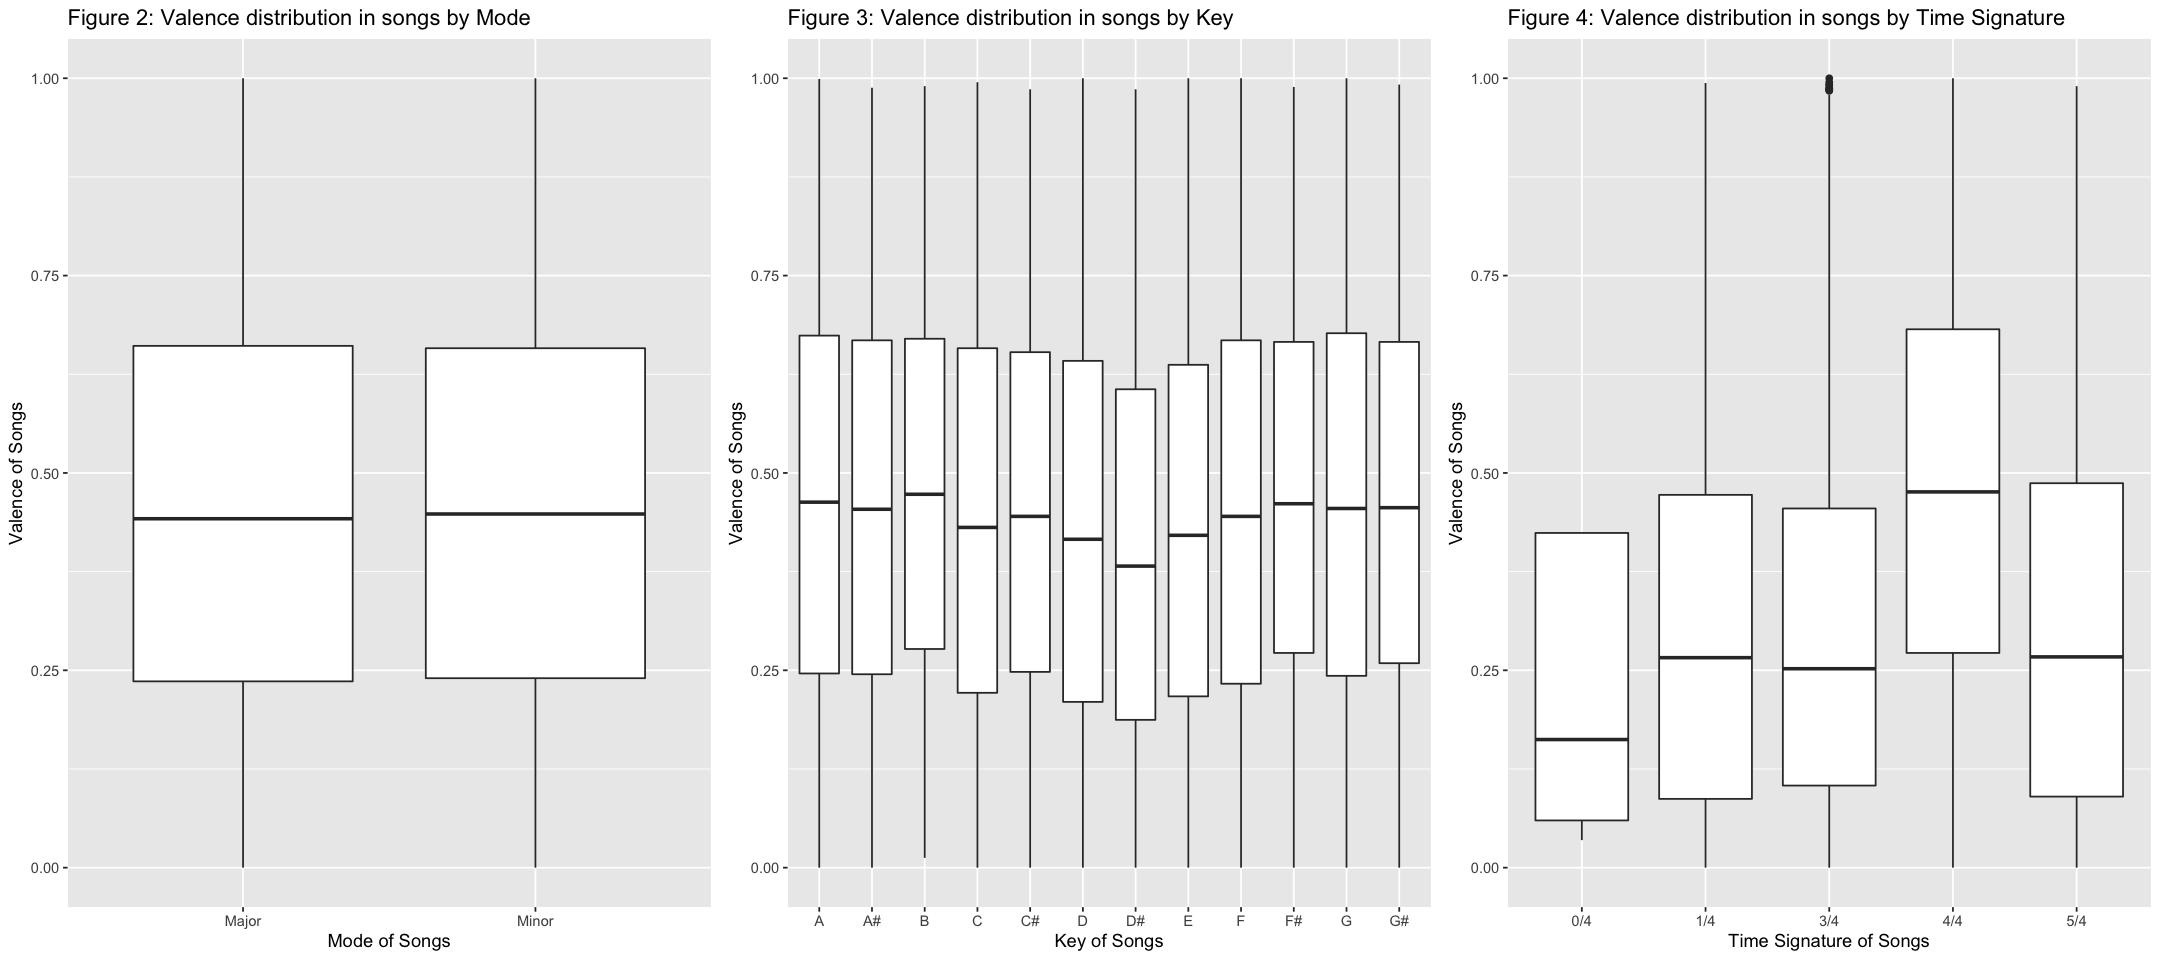

In [6]:
# Visualise the distribution of valence among different levels of categorical features, note that the response variable(valence) is plotted on the y axis from here onwards
options(repr.plot.width = 18, repr.plot.height = 8)
mode_plot = spotify %>%
ggplot() +
geom_boxplot(aes(y = valence, x = mode)) + 
labs(x = "Mode of Songs", y = "Valence of Songs", title = "Figure 2: Valence distribution in songs by Mode")

key_plot = spotify %>%
ggplot() +
geom_boxplot(aes(y = valence, x = key)) + 
labs(x = "Key of Songs", y = "Valence of Songs", title = "Figure 3: Valence distribution in songs by Key")

t_plot = spotify %>%
ggplot() +
geom_boxplot(aes(y = valence, x = time_signature)) + 
labs(x = "Time Signature of Songs", y = "Valence of Songs", title = "Figure 4: Valence distribution in songs by Time Signature")


 plot_grid(mode_plot, key_plot, t_plot,
   ncol = 3
 )


The distribution of valence seems almost identical across different modes, varies slightly across different keys, and varies moderately across different time signatures.

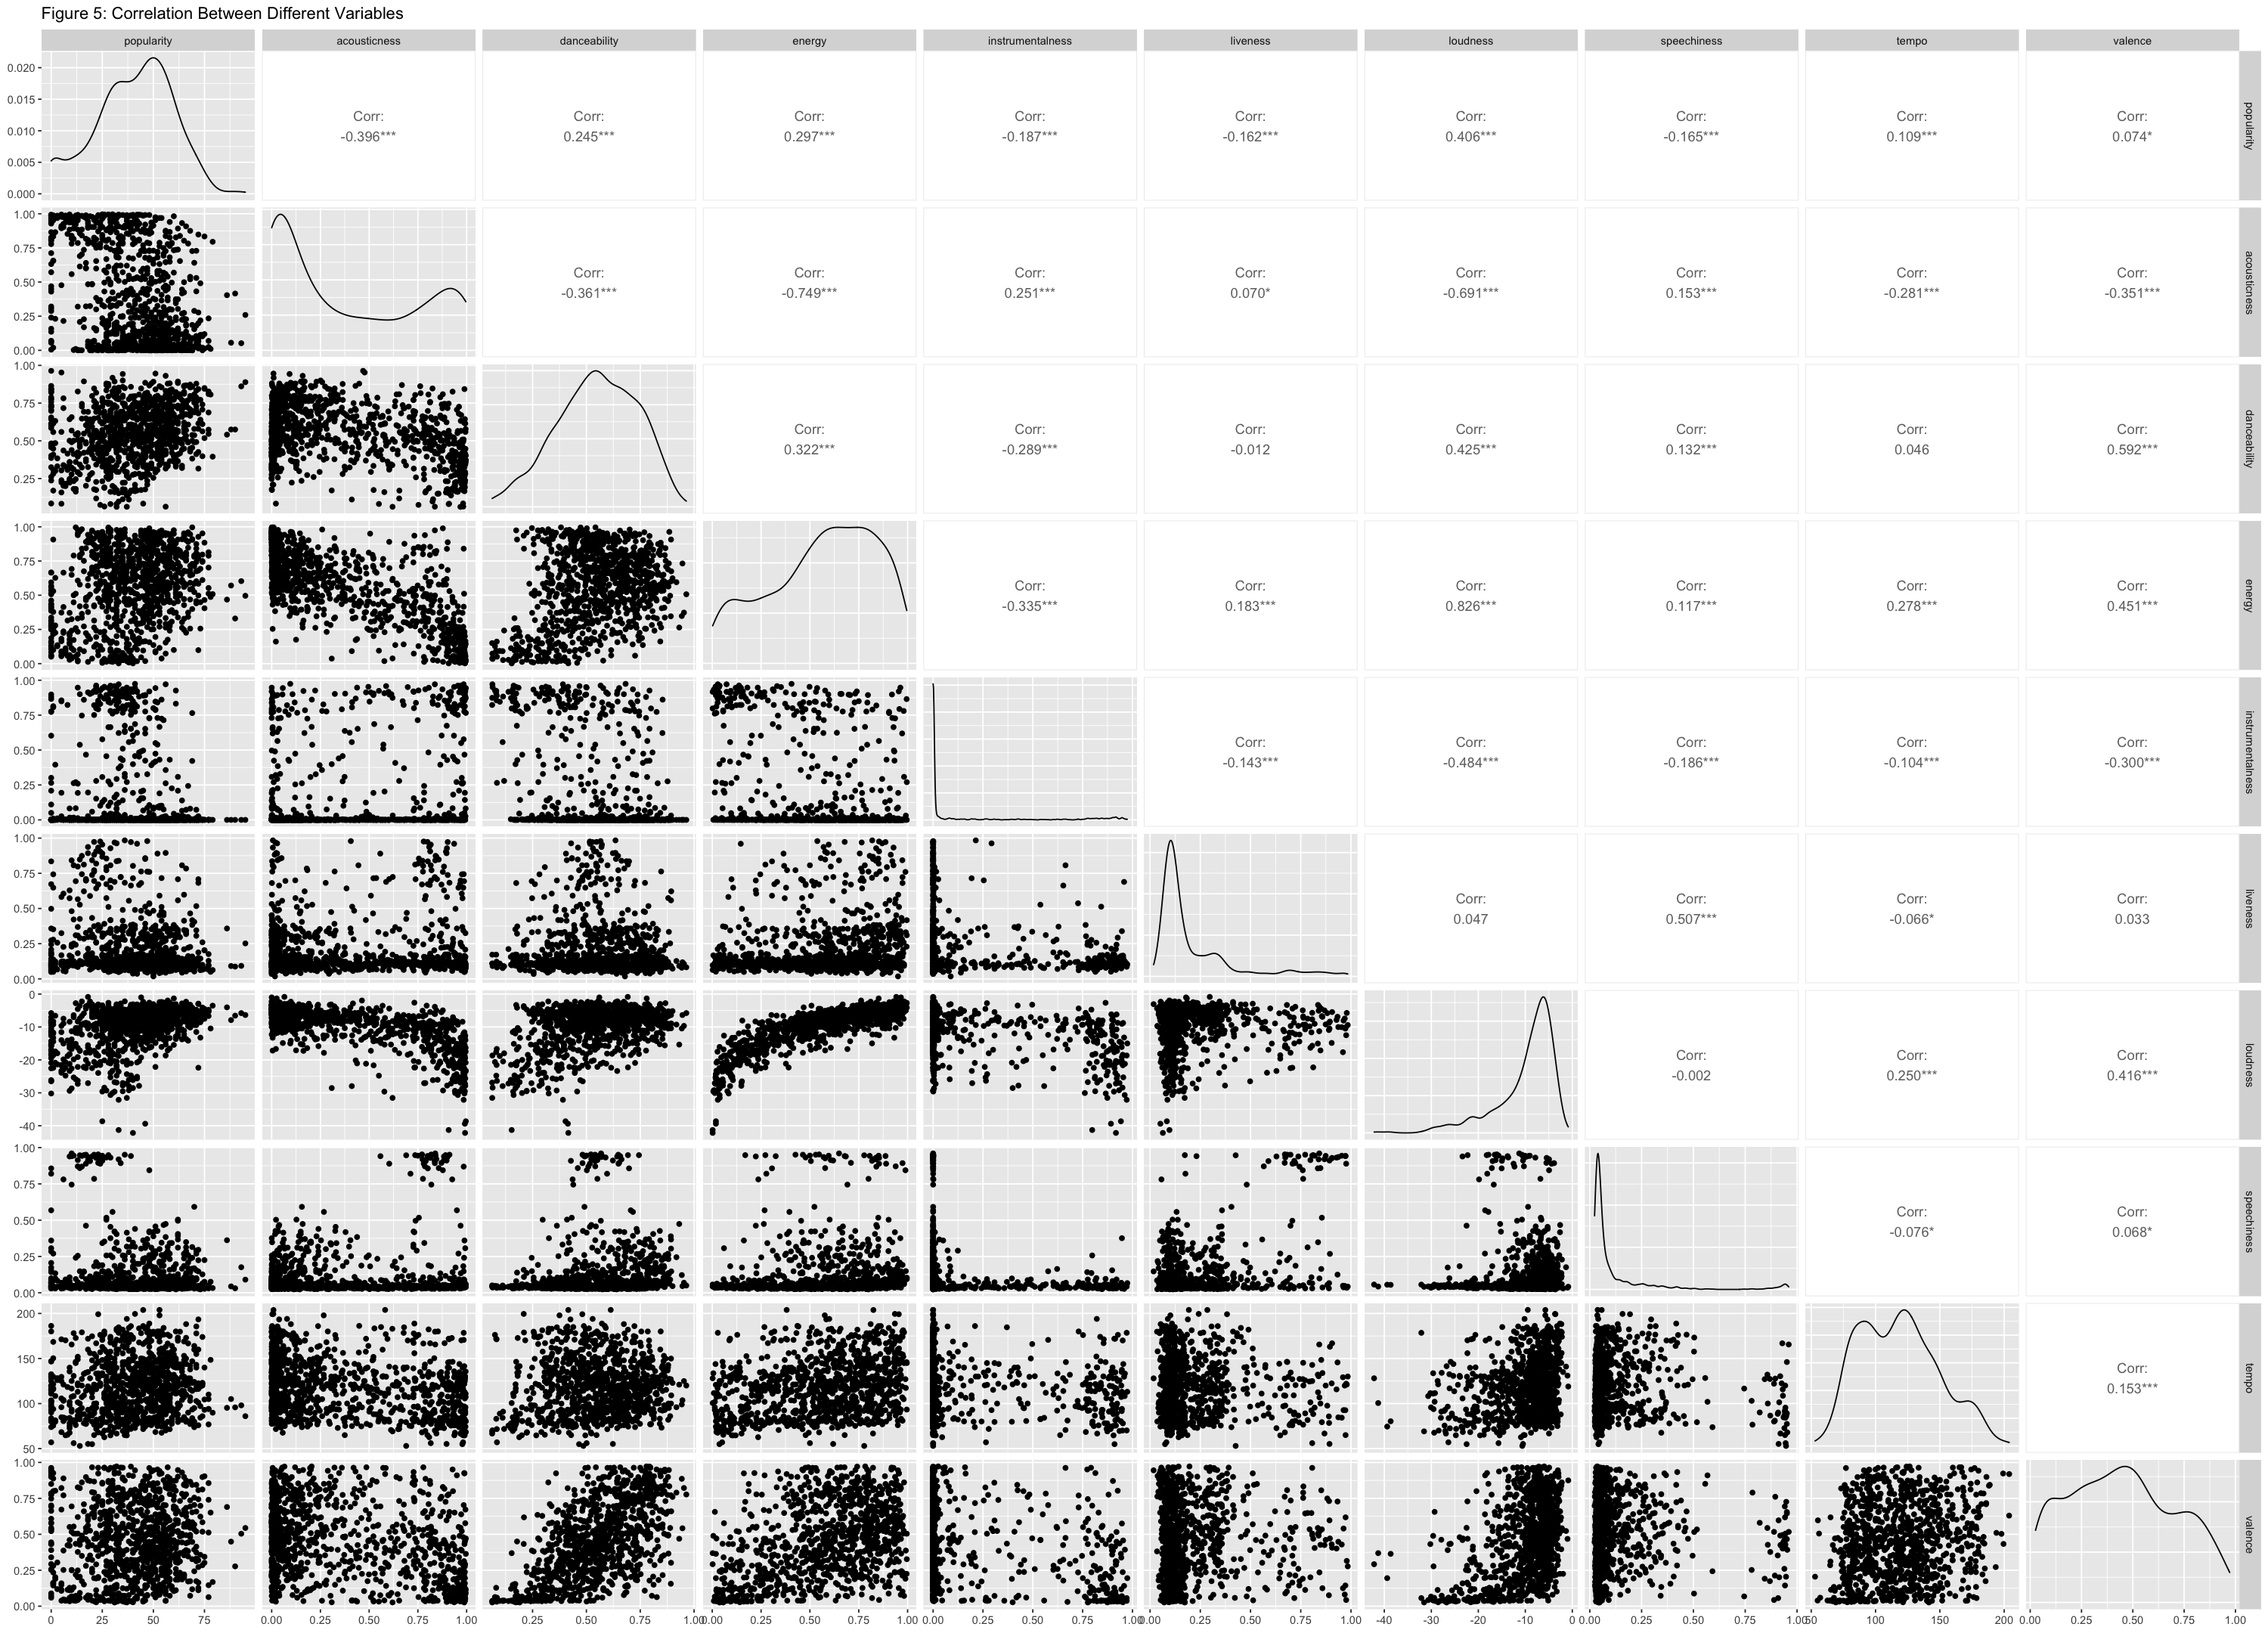

In [7]:
# Visualise the correlation between valence and numeric variables
# Note that running ggpairs with all the numeric variables was causing the kernel to timeout, so a random subsample of 1000 was used for visualization purposes
options(repr.plot.width = 25, repr.plot.height = 18)
pairs_plot = spotify %>%
            select(-genre, -key, -mode, -time_signature) %>%
            sample_n(size = 1000, replace = FALSE) %>%
            ggpairs(lower=list(combo=wrap("facethist", binwidth=0.8))) + ggtitle("Figure 5: Correlation Between Different Variables")

pairs_plot

Energy and loudness appear to be highly positively correlated (0.826) compared to the rest of the variables.

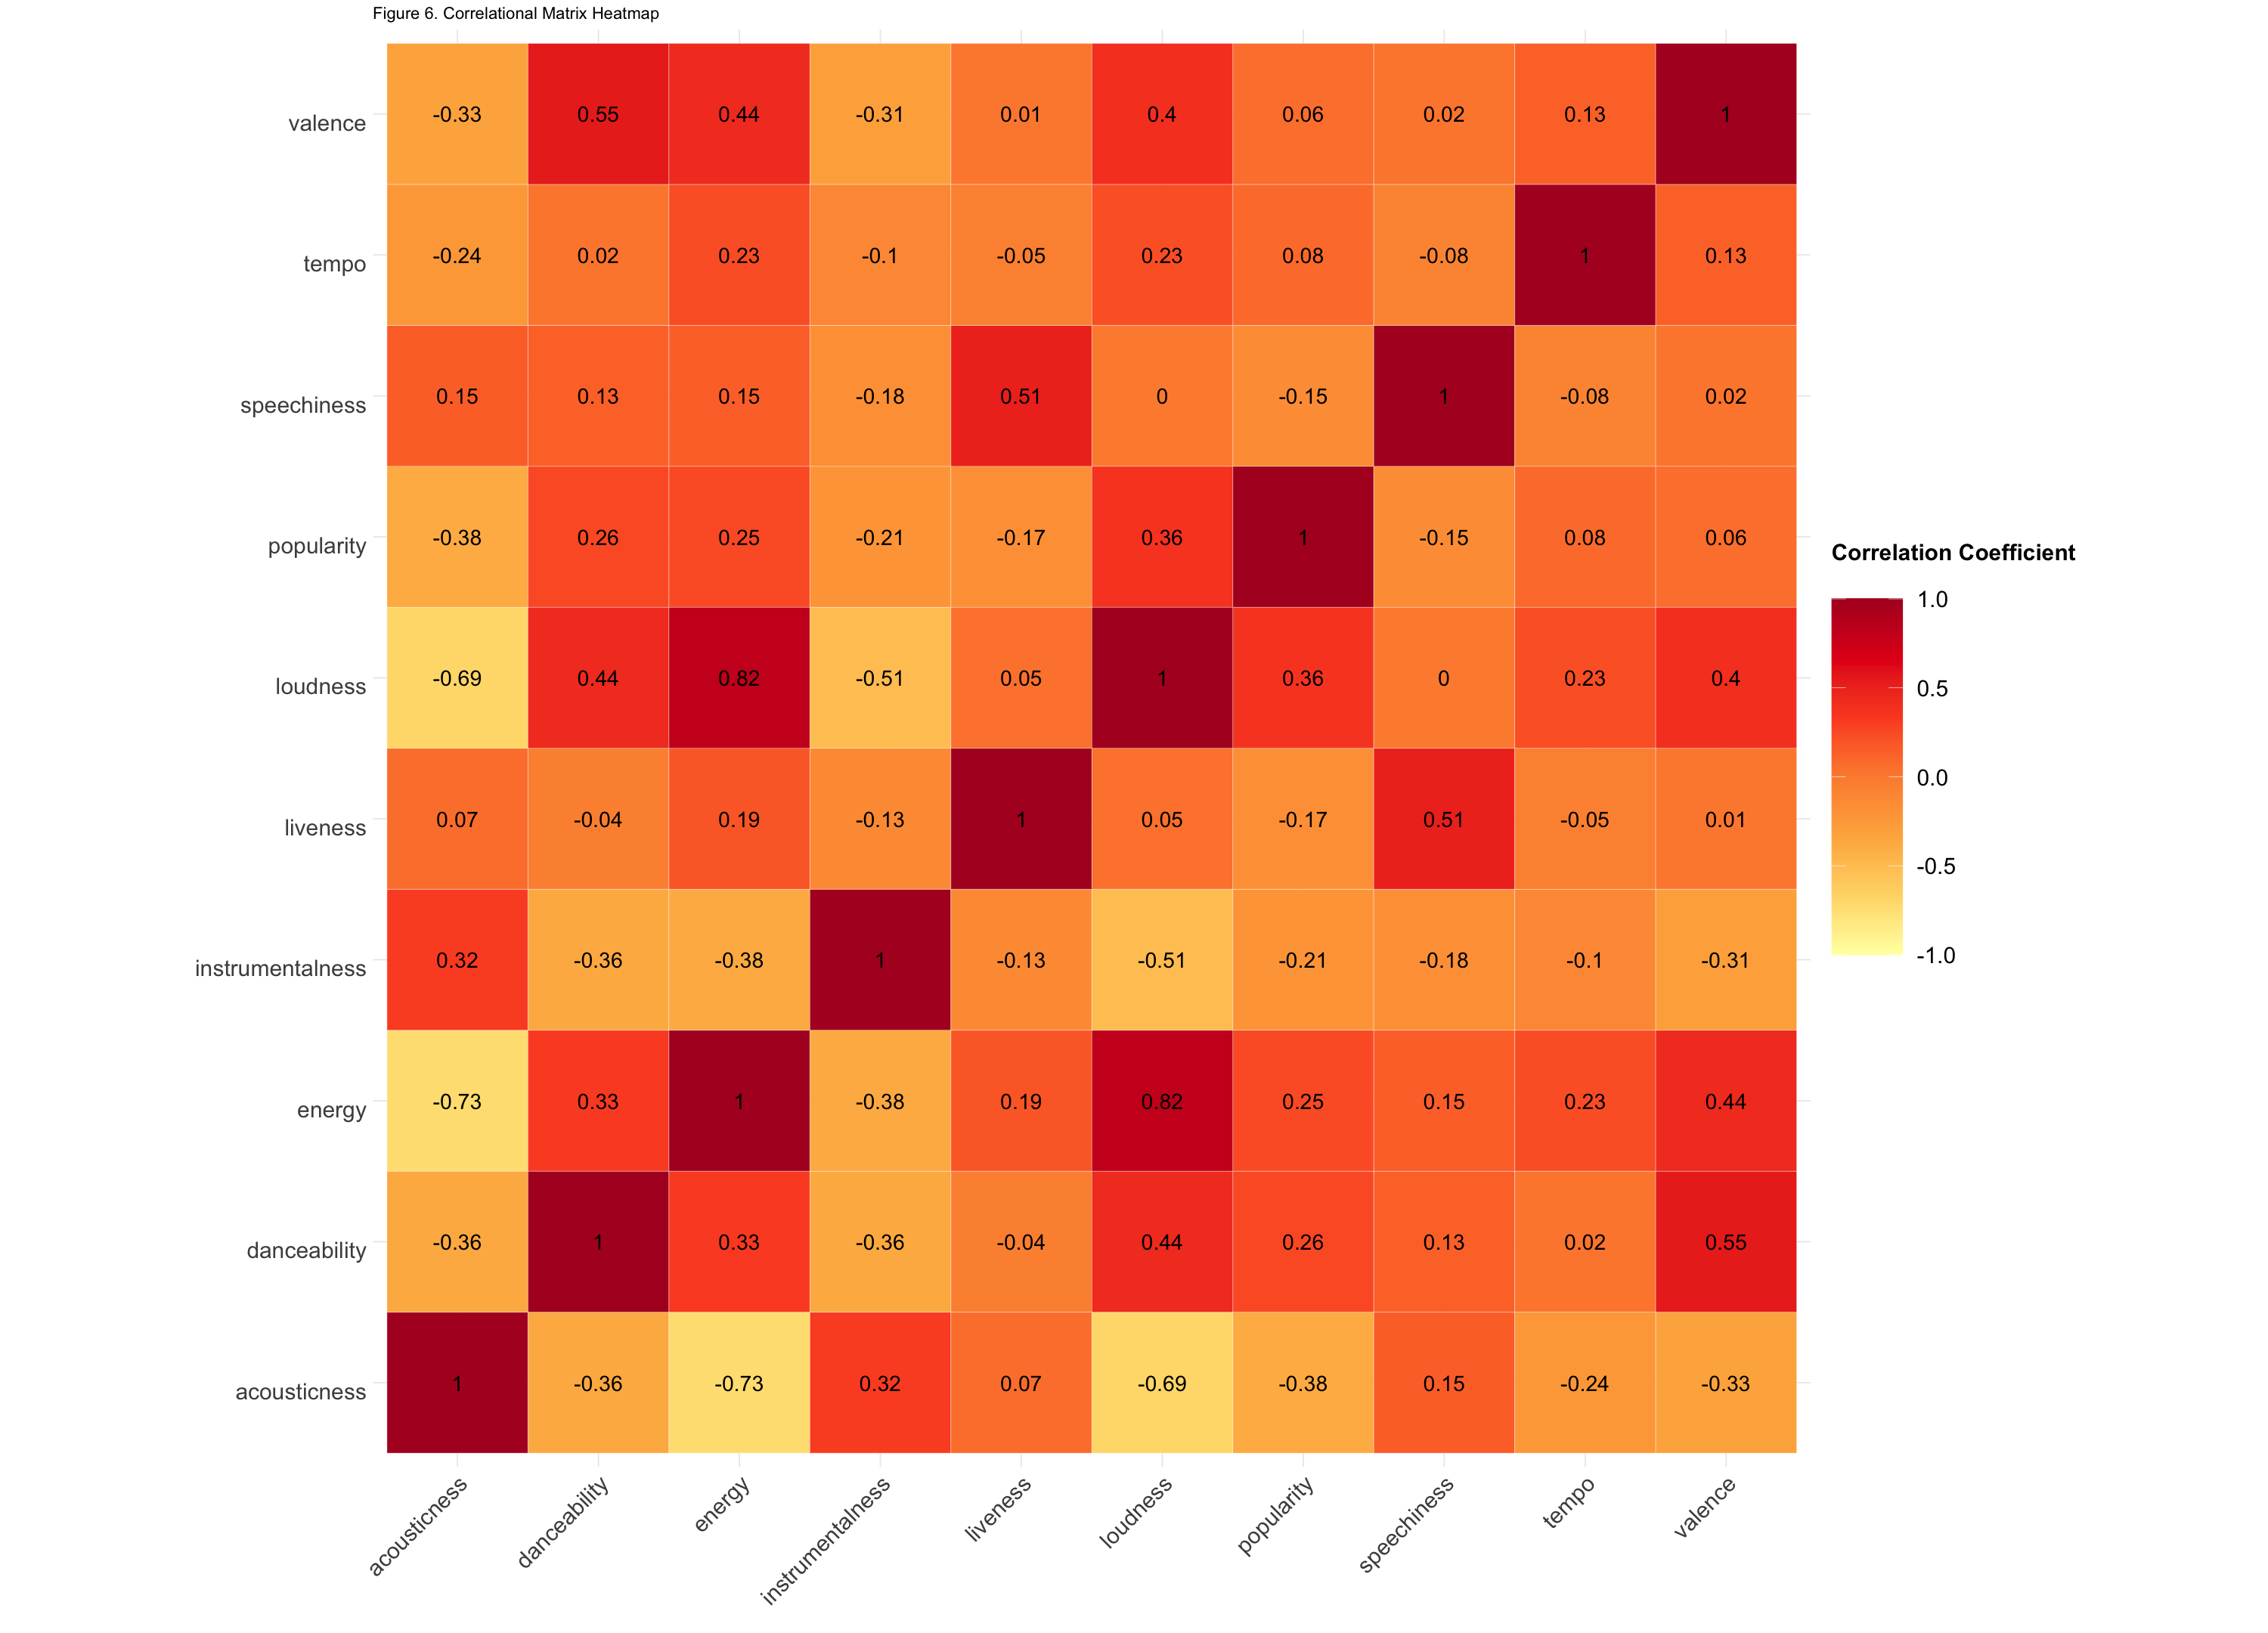

In [8]:
# Creating a correlation matrix to examine the relationship between predictive variables
corr_matrix_sample <- spotify %>%
  select(-genre, -key, -mode, -time_signature) %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix_sample <- corr_matrix_sample %>%
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = 'YlOrRd',
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "", title = "Figure 6. Correlational Matrix Heatmap") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(x = var1, y = var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix_sample

To determine if loudness and energy may be contributing to multicollinearity, we will first perform feature selection to see if they are relevant for predicting valence. Then, based on the Variance Inflation Factors, we will assess which model may be most effective for predicting new song valences.

### Variable Selection

In [9]:
# Removing categorical variables in the dataset, while it would have been nice to include these, our kernel 
# would either end up dying when we tried to fit our models or the output would be too complex to interpret due to the 
# amount of levels they introduced.
spotify <- spotify %>% select(-genre, -key, -mode, -time_signature)

# Splitting the dataset to avoid bias
spotify_split <- sample(rep(1:3, diff(floor(nrow(spotify) * c(0, 0.6, 0.8, 1)))))

# For the model
inference <- spotify[spotify_split==1,]

# For variable selection
selection <- spotify[spotify_split==2,]

# For testing our model
prediction_df <- spotify[spotify_split==3,]

In [10]:
print("Table 3: Dataset for Feature Selection")
head(selection)

[1] "Table 3: Dataset for Feature Selection"


popularity acousticness danceability energy instrumentalness liveness
1  1         0.246        0.590        0.737  0                0.1510  
2  2         0.344        0.703        0.270  0                0.1050  
3 15         0.939        0.416        0.269  0                0.1130  
4  0         0.669        0.707        0.696  0                0.1970  
5  4         0.305        0.618        0.283  0                0.2260  
6  0         0.922        0.681        0.440  0                0.0397  
  loudness speechiness tempo   valence
1  -5.559  0.0868      174.003 0.816  
2 -12.675  0.9530       82.873 0.533  
3  -8.949  0.0286       96.827 0.274  
4 -10.472  0.0280      114.752 0.833  
5 -16.222  0.8500       70.941 0.751  
6 -12.508  0.2220       84.173 0.747

In [11]:
#Run feature selection, using both forward and backward selection
spotify_sample_forward <- regsubsets(
  x = valence ~.,
  data = selection, nvmax = 50, method = "forward",
)

fwd_summary <- summary(spotify_sample_forward)

fwd_summary_df <- data.frame(
    RSQ = fwd_summary$rsq,
    RSS = fwd_summary$rss,
    ADJ.R2 = fwd_summary$adjr2,
    BIC = fwd_summary$bic
)

spotify_sample_backward <- regsubsets(
  x = valence ~.,
  data = selection, nvmax = 50, method = "backward",
)


back_summary <- summary(spotify_sample_backward)

back_summary_df <- data.frame(
    RSQ = back_summary$rsq,
    RSS = back_summary$rss,
    ADJ.R2 = back_summary$adjr2,
    BIC = back_summary$bic
)
print("Table 4: Summary of Models with different number of input variables selected by forward selection")
fwd_summary_df
print("Table 5: Summary of Models with different number of input variables selected by backward selection")
back_summary_df

[1] "Table 4: Summary of Models with different number of input variables selected by forward selection"


RSQ       RSS      ADJ.R2    BIC      
1 0.3003216 2209.607 0.3003065 -16601.32
2 0.3760347 1970.502 0.3760079 -21921.20
3 0.3943852 1912.551 0.3943461 -23299.84
4 0.4073846 1871.498 0.4073336 -24299.05
5 0.4141943 1849.993 0.4141314 -24826.25
6 0.4182934 1837.048 0.4182184 -25142.33
7 0.4219783 1825.411 0.4218914 -25427.37
8 0.4287164 1804.132 0.4286181 -25962.39
9 0.4289918 1803.262 0.4288813 -25974.08

[1] "Table 5: Summary of Models with different number of input variables selected by backward selection"


RSQ       RSS      ADJ.R2    BIC      
1 0.3003216 2209.607 0.3003065 -16601.32
2 0.3760347 1970.502 0.3760079 -21921.20
3 0.3943852 1912.551 0.3943461 -23299.84
4 0.4073846 1871.498 0.4073336 -24299.05
5 0.4141943 1849.993 0.4141314 -24826.25
6 0.4181731 1837.428 0.4180981 -25132.71
7 0.4243972 1817.772 0.4243106 -25622.56
8 0.4287164 1804.132 0.4286181 -25962.39
9 0.4289918 1803.262 0.4288813 -25974.08

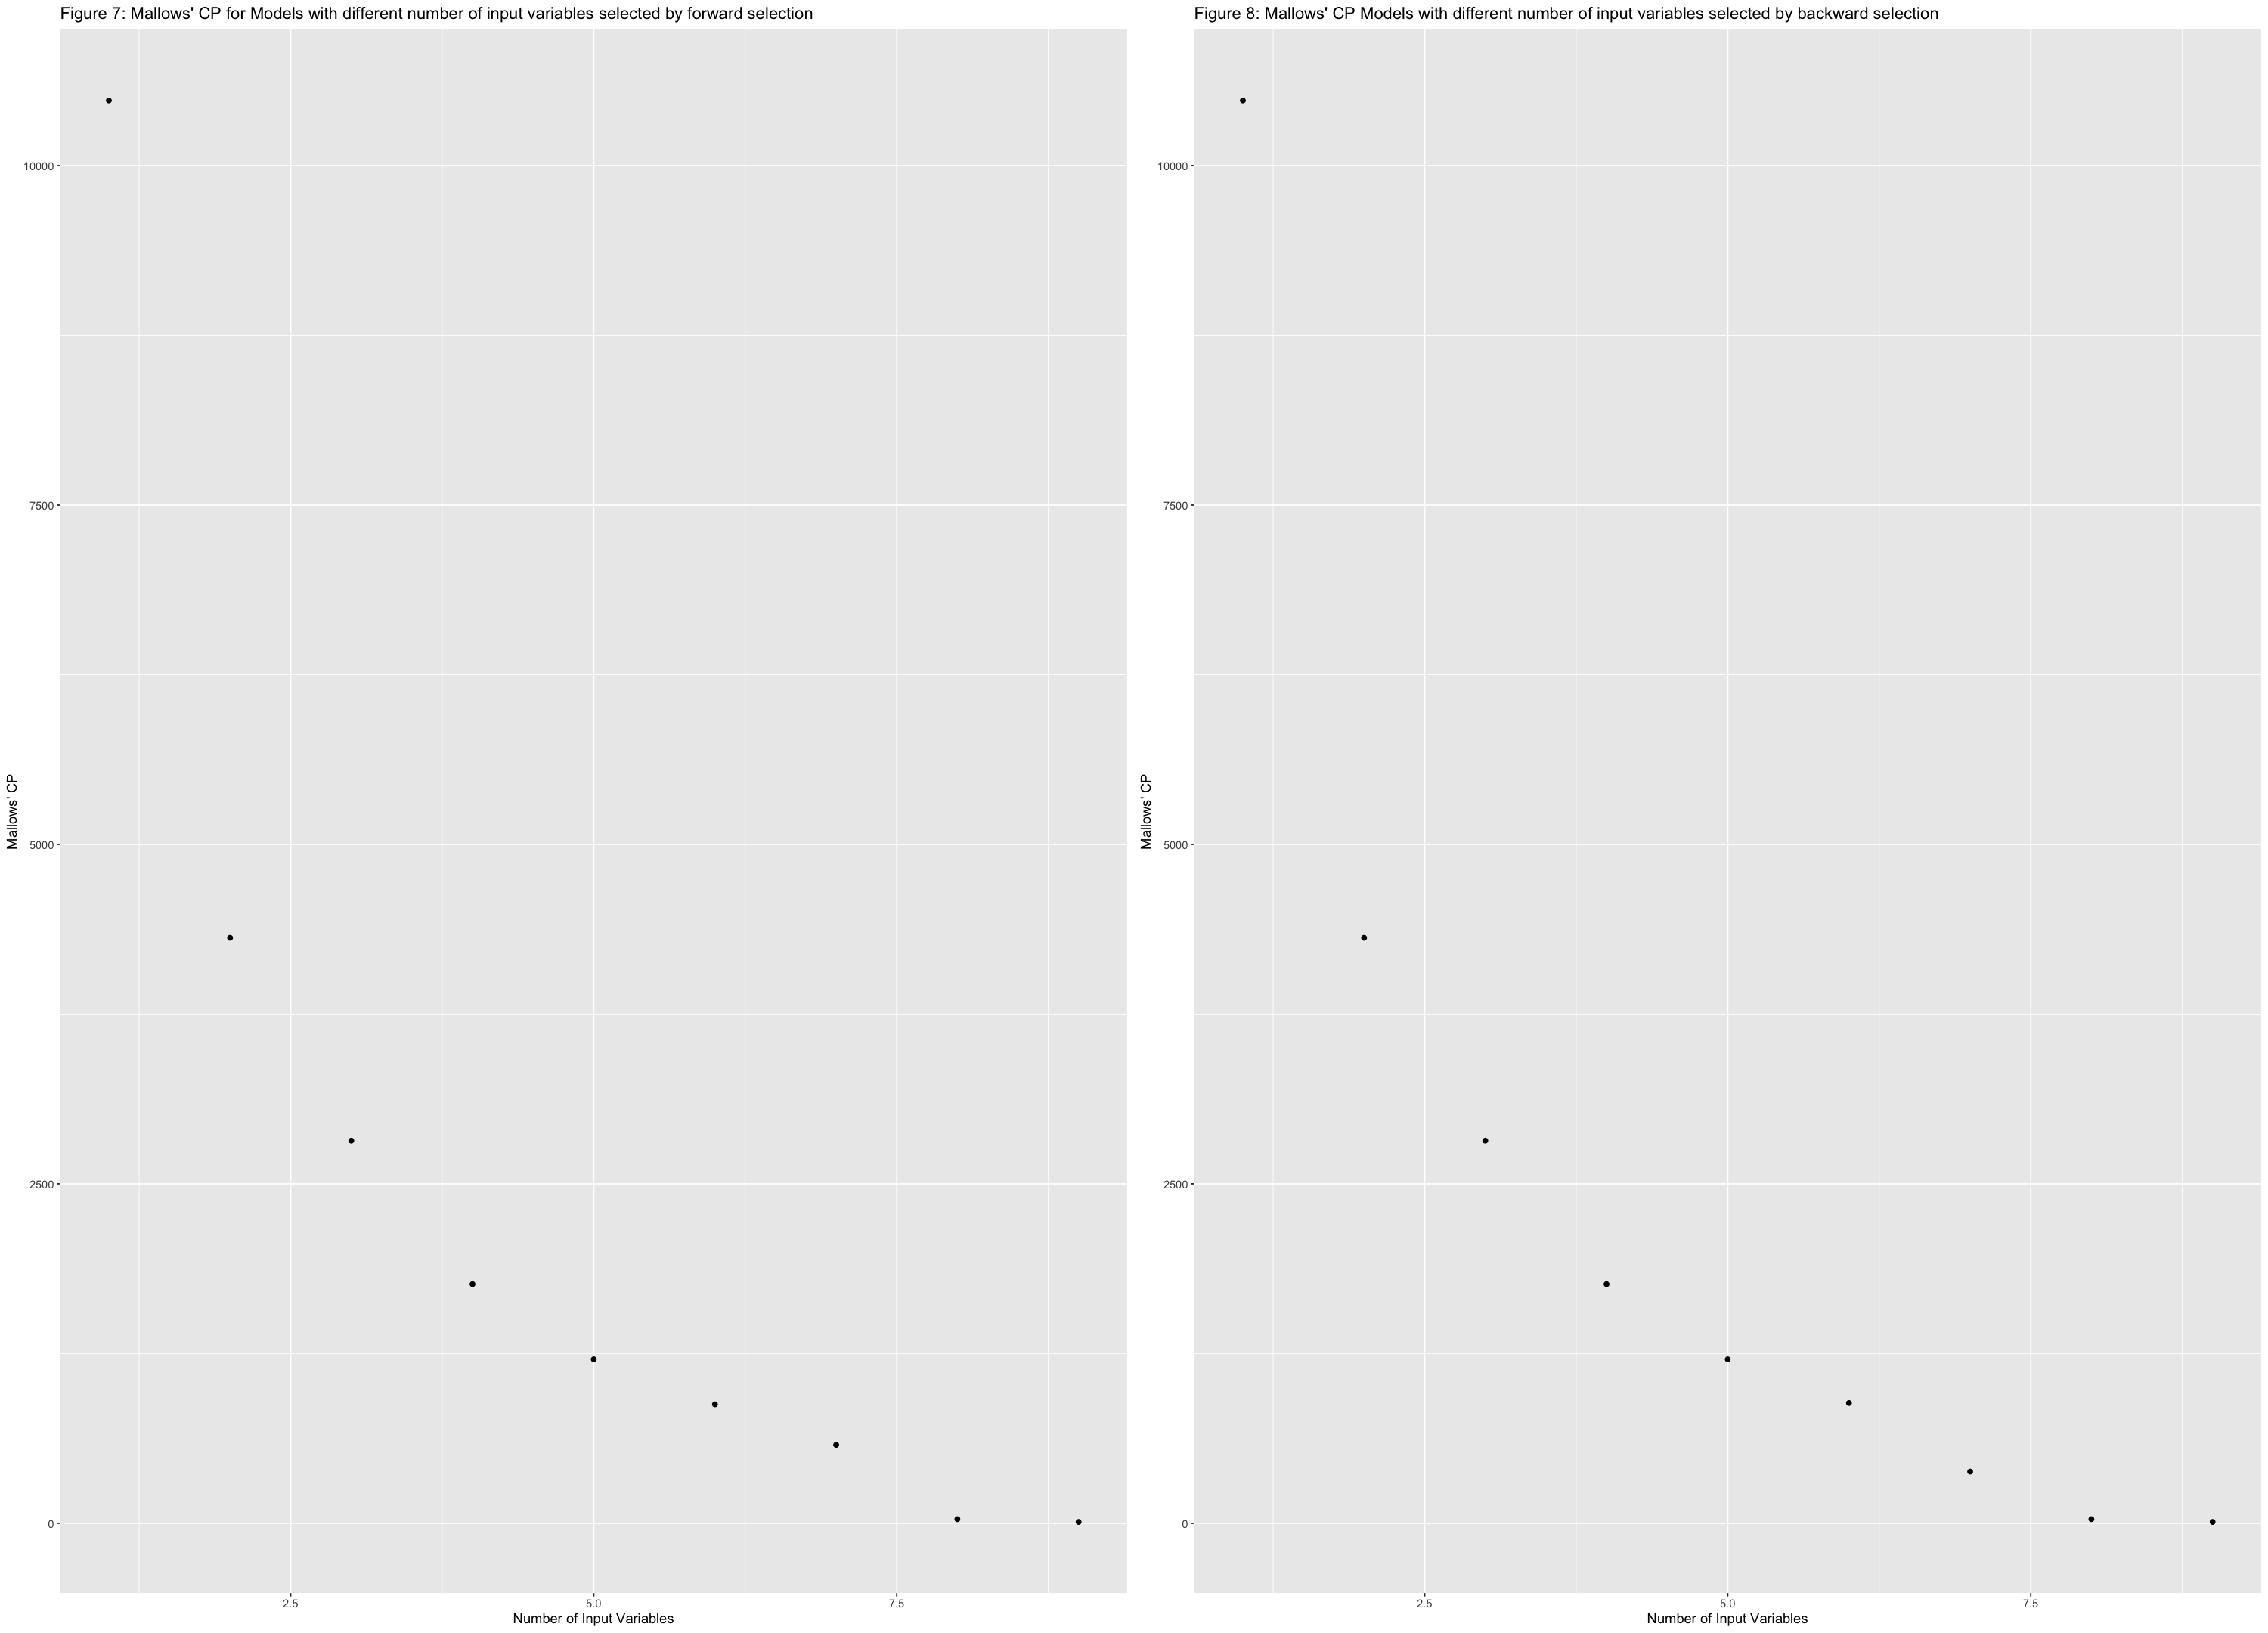

In [12]:
# Making scatter graphs to compare mallow's cp for the different models, so that we can pick the one with least apparent bias.
fwd_candidates <- tibble(
  n_input_variables = 1:9,
  C_p = fwd_summary$cp
)
fwd_plot = fwd_candidates %>%
            ggplot() +
            geom_point(aes(y = C_p, x = n_input_variables)) +
            labs(x = "Number of Input Variables",
                y = "Mallows' CP", 
                title = "Figure 7: Mallows' CP for Models with different number of input variables selected by forward selection")


back_candidates <- tibble(
  n_input_variables = 1:9,
  C_p = back_summary$cp
)
back_plot =  back_candidates %>%
            ggplot() +
            geom_point(aes(y = C_p, x = n_input_variables)) +
            labs(x = "Number of Input Variables",
                y = "Mallows' CP",
                title = "Figure 8: Mallows' CP Models with different number of input variables selected by backward selection")

 plot_grid(fwd_plot, back_plot,
   ncol = 2
 )

Looking at these values, we can see that Mallow's cp is lowest with all the predictors whether we do forward or backward selection, thus we will not remove any variables from our model.

### Variable Selection using Lasso

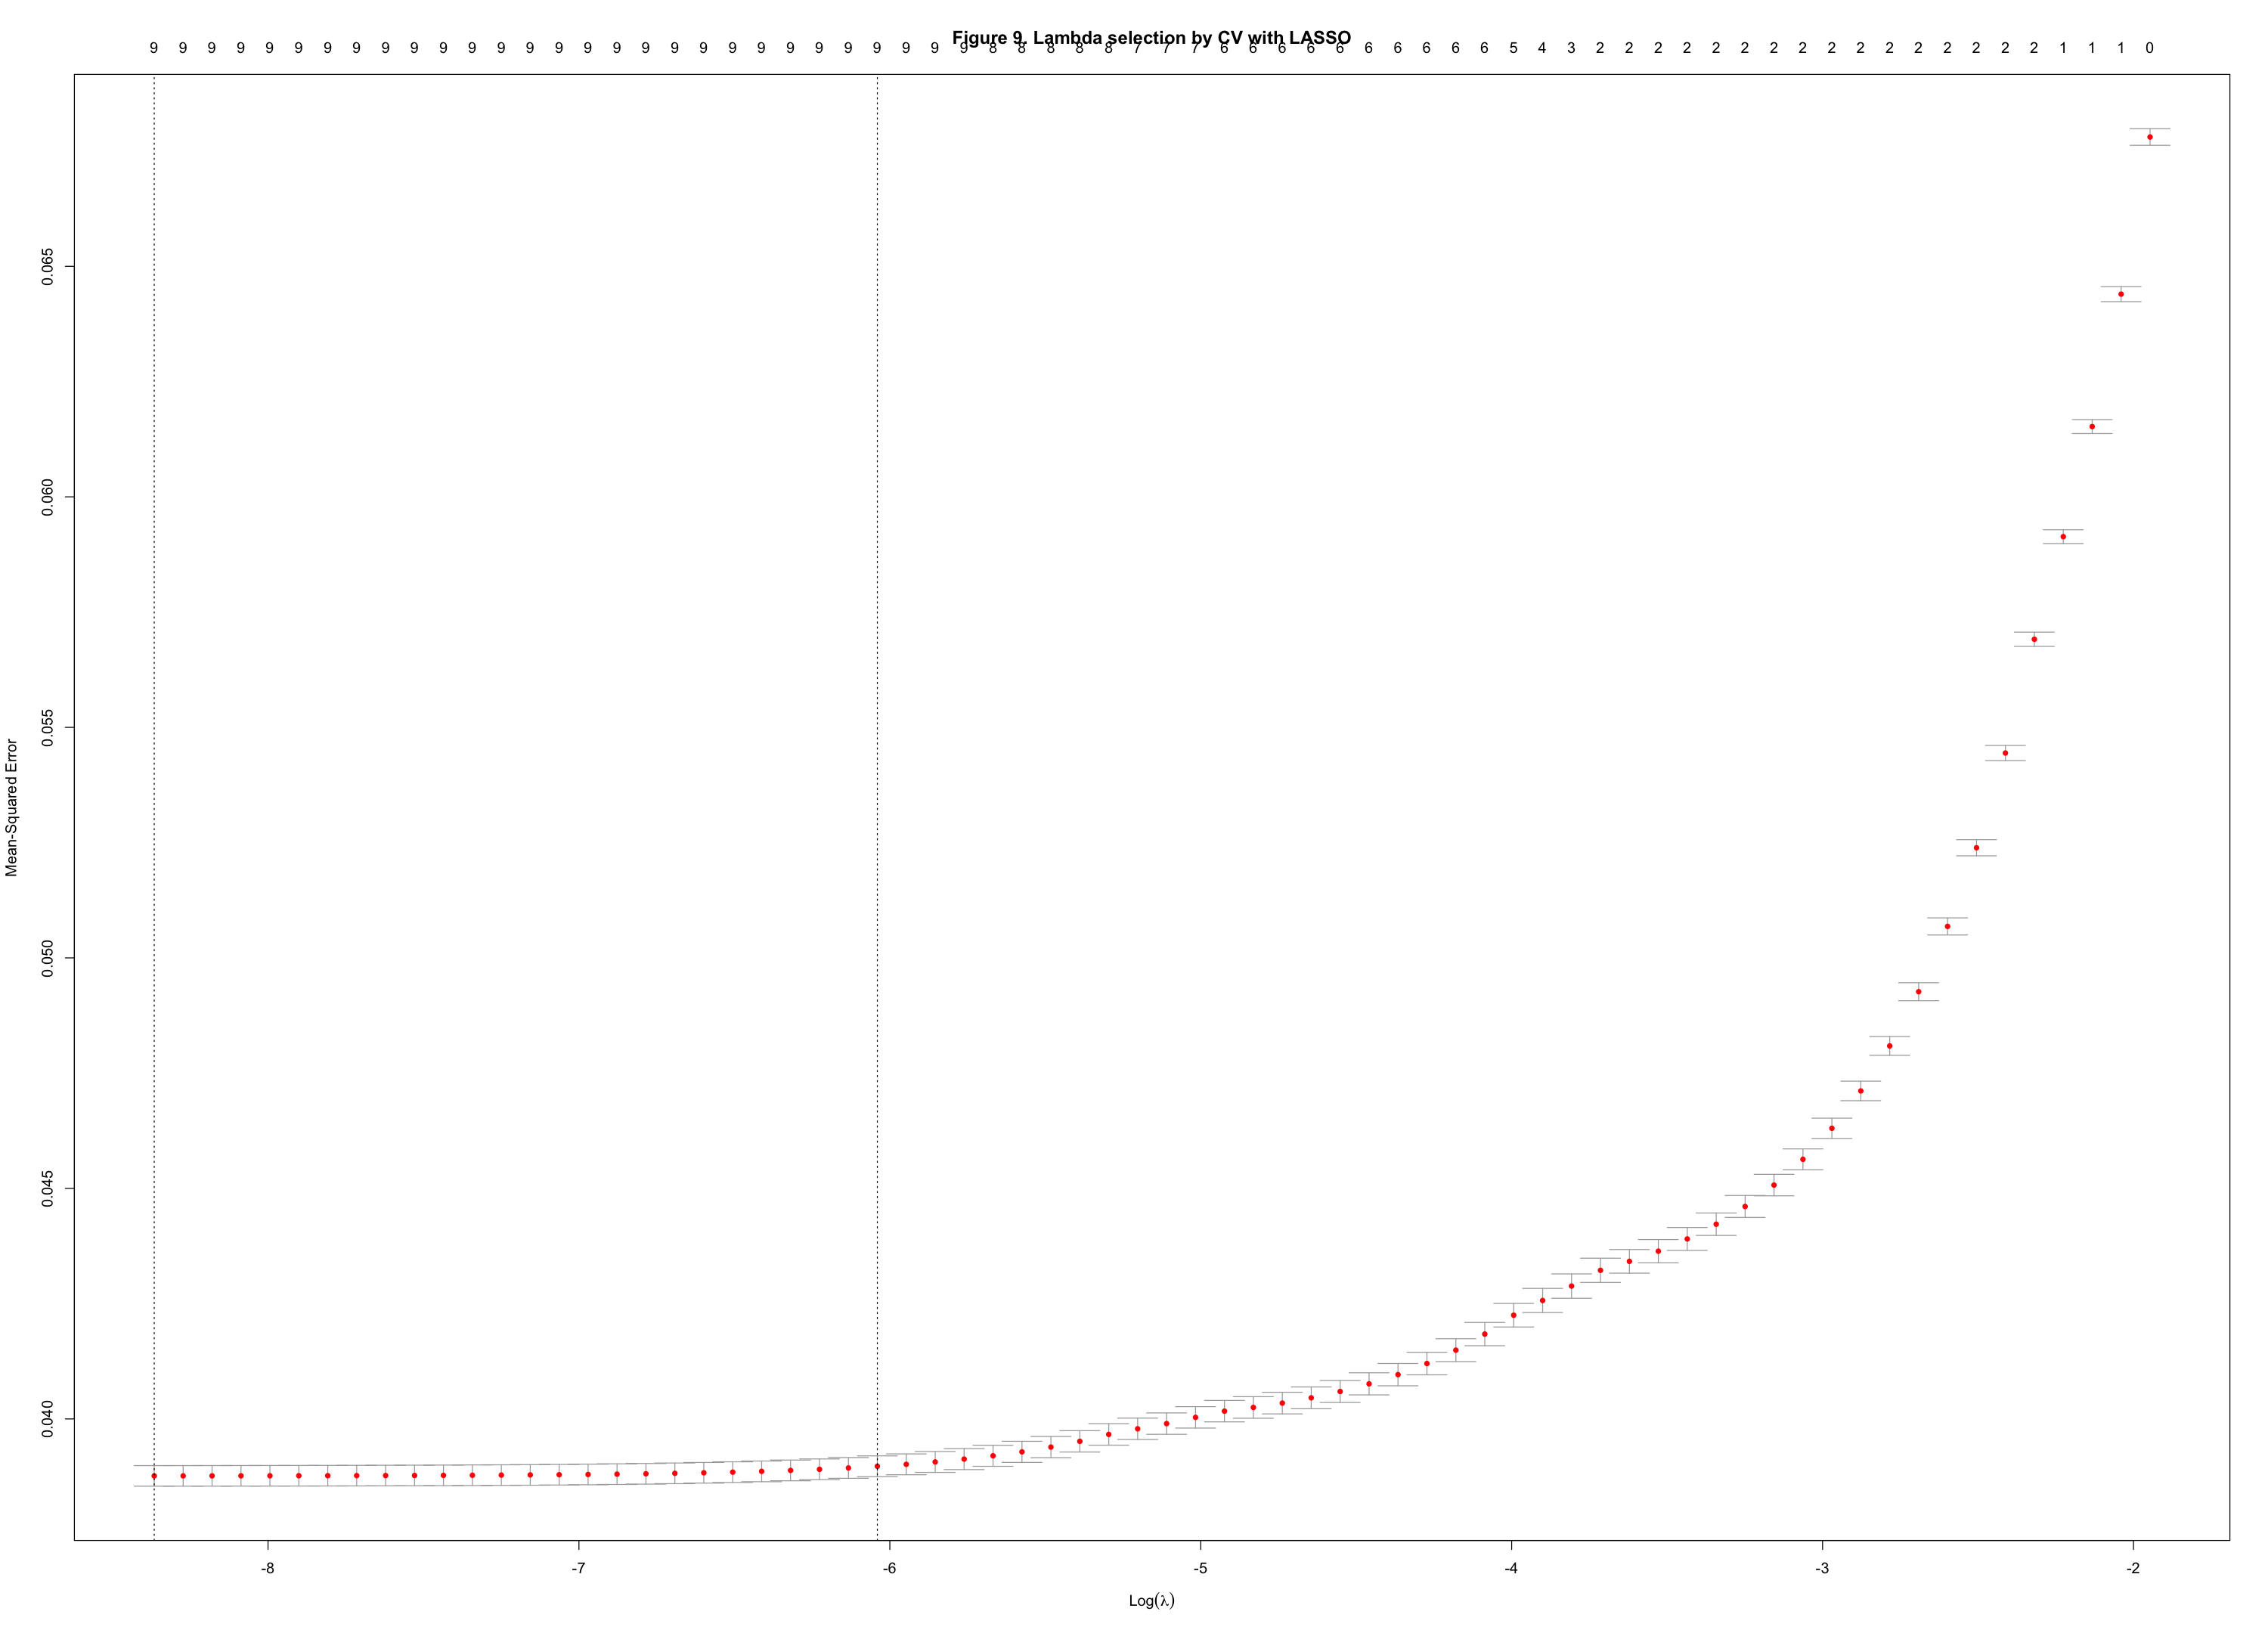

In [13]:
# Running Feature selection using Lasso
lasso_model <-
    cv.glmnet(x = selection %>% select(-valence) %>% as.matrix(), 
              y = selection %>% select(valence) %>% as.matrix(), 
              alpha = 1)
plot(lasso_model, main = "Figure 9. Lambda selection by CV with LASSO")

### Feature Selection using Ridge

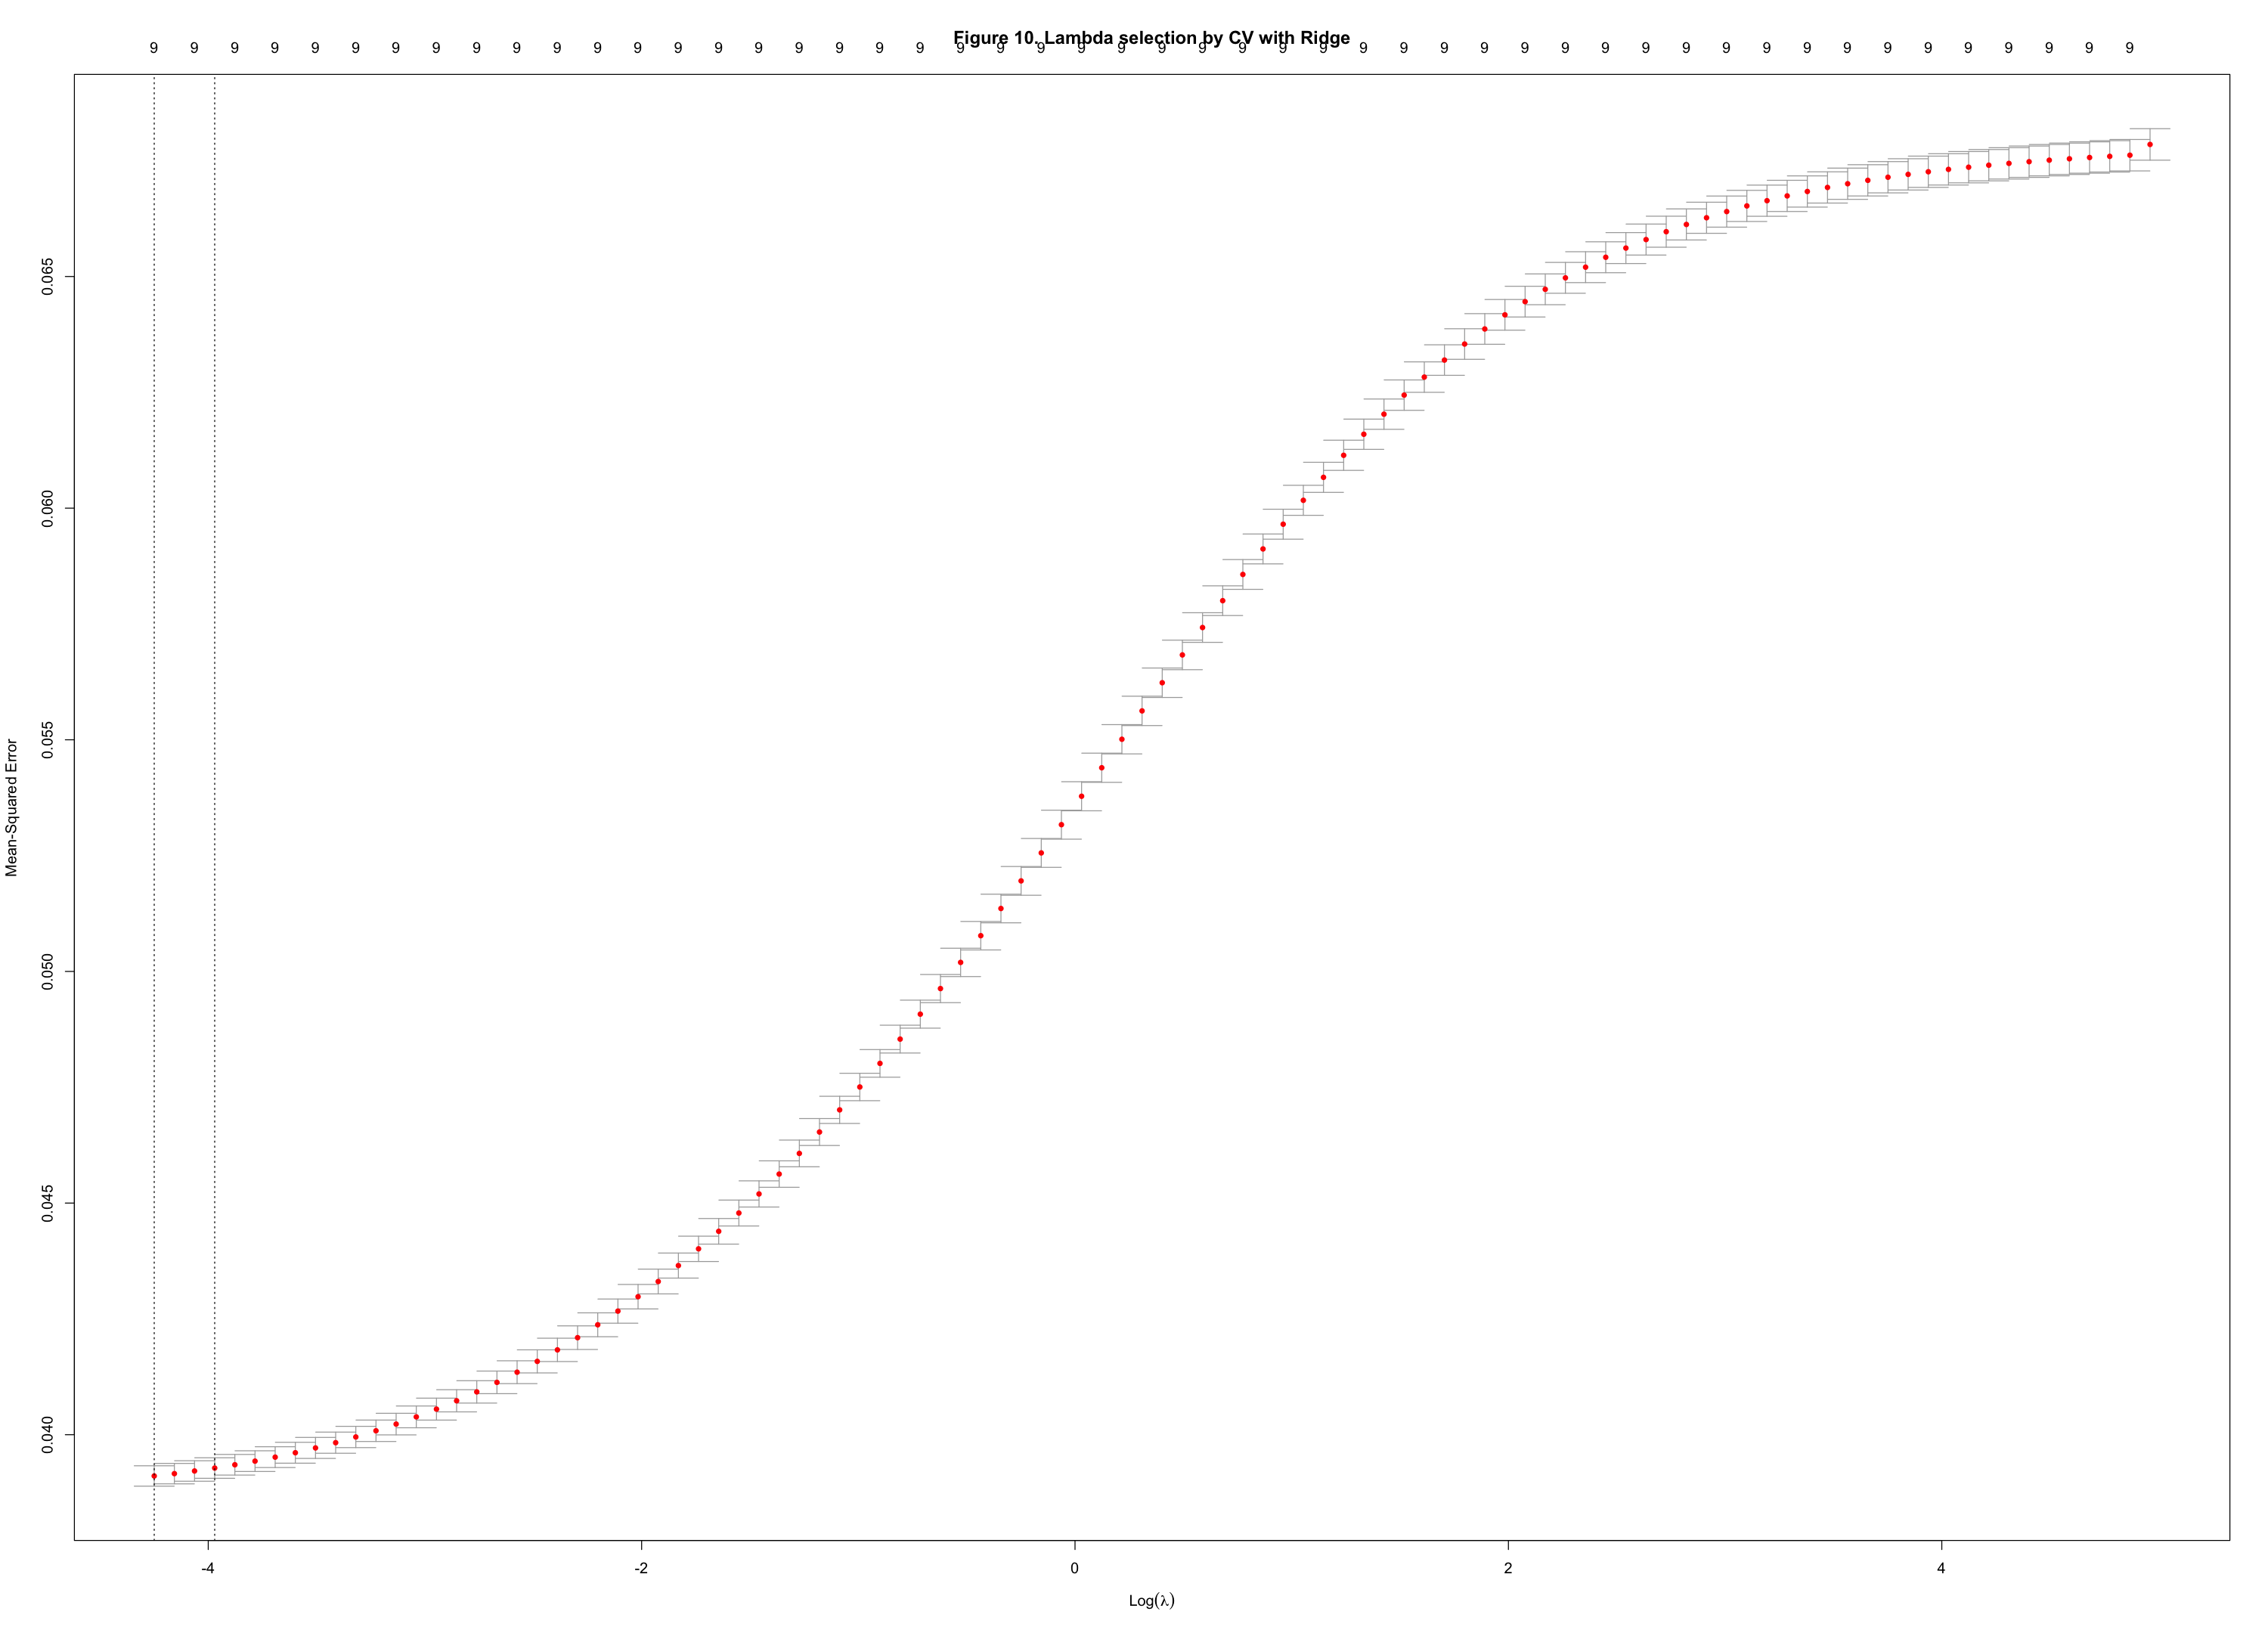

In [14]:
# Running Feature selection using Ridge
ridge_model <-
    cv.glmnet(x = selection %>% select(-valence) %>% as.matrix(), 
              y = selection %>% select(valence) %>% as.matrix(), 
              alpha = 0)
plot(ridge_model, main = "Figure 10. Lambda selection by CV with Ridge")

In [15]:
# Full model via ordinary least squares
full_model <- lm(valence ~ ., data = selection)

# LASSO model with lambda producing lowest MSE
min_lasso_model <- glmnet(
    x = selection %>% select(-valence) %>% as.matrix(),
    y = selection %>% select(valence) %>% as.matrix(),
    alpha = 1,
    lambda = lasso_model$lambda.min)

min_lasso_model.coef <- min_lasso_model$beta

# Ridge model with lambda producing lowest MSE
min_ridge_model <- glmnet(
    x = selection %>% select(-valence) %>% as.matrix(),
    y = selection %>% select(valence) %>% as.matrix(),
    alpha = 0,
    lambda = ridge_model$lambda.min)

min_ridge_model.coef <- min_ridge_model$beta

# Coefficients
model_coefs <- cbind(
  Full_OLS = coef(full_model),
  LASSO_min = c(
    min_lasso_model$a0,
    as.vector(min_lasso_model.coef)
  ),
  Ridge_min = c(
  min_ridge_model$a0,
  as.vector(min_ridge_model.coef)
  )
)
print("Table 6: Coefficients of the Features in our selected Model")
model_coefs

[1] "Table 6: Coefficients of the Features in our selected Model"


Full_OLS      LASSO_min     Ridge_min    
(Intercept)      -0.2916170436 -0.2804840701 -0.1334691255
popularity       -0.0020396429 -0.0020323882 -0.0019749796
acousticness      0.1072478073  0.1036458309  0.0624365757
danceability      0.7350852149  0.7317071454  0.6660428284
energy            0.5151954482  0.5058451576  0.3875692198
instrumentalness -0.0897727031 -0.0875542124 -0.0771750463
liveness         -0.0264253207 -0.0245586212 -0.0202942714
loudness         -0.0073308318 -0.0070035725 -0.0032051974
speechiness      -0.2378488897 -0.2335692727 -0.1789171393
tempo             0.0005705718  0.0005620442  0.0005371072

In [16]:
summary(full_model)


Call:
lm(formula = valence ~ ., data = selection)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.71965 -0.13509 -0.00488  0.13676  0.86106 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.916e-01  9.679e-03 -30.127  < 2e-16 ***
popularity       -2.040e-03  5.661e-05 -36.033  < 2e-16 ***
acousticness      1.072e-01  4.308e-03  24.893  < 2e-16 ***
danceability      7.351e-01  5.837e-03 125.933  < 2e-16 ***
energy            5.152e-01  7.362e-03  69.976  < 2e-16 ***
instrumentalness -8.977e-02  3.664e-03 -24.501  < 2e-16 ***
liveness         -2.643e-02  5.578e-03  -4.738 2.17e-06 ***
loudness         -7.331e-03  3.104e-04 -23.614  < 2e-16 ***
speechiness      -2.378e-01  6.252e-03 -38.044  < 2e-16 ***
tempo             5.706e-04  3.085e-05  18.493  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1969 on 46535 degrees of freedom
Multiple R-squared:  0.429,	Adjusted R-squ

Lasso and Ridge do not remove any features similar to the greedy selection methods, and the full model indicates that all variables are significant. Therefore, we will be keeping all of the predictive variables for our model.

In [17]:
# Check for multicollinearity in the predictors
lasso_variables_vif <- 
   vif(lm(valence ~ popularity + acousticness + danceability + energy + instrumentalness +
         liveness + loudness + speechiness + tempo, data = selection))

lasso_variables_vif

popularity     acousticness     danceability           energy 
        1.275614         2.813558         1.407728         4.523510 
instrumentalness         liveness         loudness      speechiness 
        1.473079         1.474976         4.198713         1.621138 
           tempo 
        1.088418

While the highest VIFs correspond to the variables with the highest correlation (energy and loudness), there is no concerning presence of multicollinearity following James et al. (2013)'s method (only exceeding 5 or 10 poses problems). However, for our inference model, we will test to see if a model with energy & loudness may perform better or worse than without the variables to further prove that all variables are relevant.

### Inference

In [18]:
#Dataset used to construct our models
print("Table 7: Dataset for Inference")
head(inference)

[1] "Table 7: Dataset for Inference"


popularity acousticness danceability energy instrumentalness liveness
1  0         0.61100      0.389        0.9100 0.00000          0.3460  
2  0         0.70300      0.240        0.3260 0.00000          0.0985  
3  4         0.95000      0.331        0.2250 0.12300          0.2020  
4  0         0.74900      0.578        0.0948 0.00000          0.1070  
5  0         0.00104      0.734        0.4810 0.00086          0.0765  
6 10         0.31900      0.598        0.7050 0.00125          0.3490  
  loudness speechiness tempo   valence
1  -1.828  0.0525      166.969 0.814  
2 -12.178  0.0395      171.758 0.227  
3 -21.150  0.0456      140.576 0.390  
4 -14.970  0.1430       87.479 0.358  
5  -7.725  0.0460      125.080 0.765  
6  -7.790  0.0281      137.496 0.718

In [19]:
# Model constructed using chosen covariates, without interaction
spotify_model <- lm(valence ~ ., data = inference)
spotify_model_summary = tidy(spotify_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 4)
print("Table 8: Coefficients for Full Model (Without Interactions)")
spotify_model_summary

[1] "Table 8: Coefficients for Full Model (Without Interactions)"


term             estimate std.error statistic p.value conf.low conf.high
1  (Intercept)      -0.2846  0.0056    -50.9380  0       -0.2956  -0.2737  
2  popularity       -0.0020  0.0000    -61.7190  0       -0.0021  -0.0019  
3  acousticness      0.1054  0.0025     42.5363  0        0.1006   0.1103  
4  danceability      0.7315  0.0034    217.3005  0        0.7249   0.7381  
5  energy            0.5104  0.0042    120.3097  0        0.5021   0.5187  
6  instrumentalness -0.0934  0.0021    -44.2868  0       -0.0976  -0.0893  
7  liveness         -0.0215  0.0032     -6.7032  0       -0.0278  -0.0152  
8  loudness         -0.0074  0.0002    -41.0625  0       -0.0078  -0.0070  
9  speechiness      -0.2408  0.0036    -66.4935  0       -0.2479  -0.2337  
10 tempo             0.0005  0.0000     29.9589  0        0.0005   0.0006

In [20]:
# Model constructed using covariates, without loudness and energy nor interactions
spotify_model_no_le <- lm(valence ~ popularity + acousticness + danceability + instrumentalness + liveness + speechiness + tempo, data = inference)
spotify_model_no_le_summary <- tidy(spotify_model_no_le, conf.int = TRUE) %>% mutate_if(is.numeric, round, 4)
print("Table 9: Coefficients for Model without Loudness and Energy (Without Interactions)")
spotify_model_no_le_summary

[1] "Table 9: Coefficients for Model without Loudness and Energy (Without Interactions)"


term             estimate std.error statistic p.value conf.low conf.high
1 (Intercept)       0.1166  0.0038     30.3132  0        0.1091   0.1242  
2 popularity       -0.0022  0.0000    -64.8354  0       -0.0023  -0.0021  
3 acousticness     -0.0988  0.0019    -52.1684  0       -0.1026  -0.0951  
4 danceability      0.7096  0.0035    204.1392  0        0.7027   0.7164  
5 instrumentalness -0.0972  0.0021    -46.6662  0       -0.1013  -0.0931  
6 liveness          0.0622  0.0033     18.6815  0        0.0557   0.0687  
7 speechiness      -0.1187  0.0037    -32.3019  0       -0.1259  -0.1115  
8 tempo             0.0007  0.0000     39.6812  0        0.0007   0.0008

In [21]:
print("Table 10: Summary Statistics for the Full Model (Without Interactions)")
glance(spotify_model)

[1] "Table 10: Summary Statistics for the Full Model (Without Interactions)"


r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.4266392 0.4266023     0.1964735 11543.92  0       9  29089.47 -58156.94
  BIC       deviance df.residual nobs  
1 -58048.63 5389.78  139625      139635

In [22]:
print("Table 11: Summary Statistics for the Reduced Model (Without Interactions)")
glance(spotify_model_no_le)

[1] "Table 11: Summary Statistics for the Reduced Model (Without Interactions)"


r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.3580071 0.3579749     0.2078988 11123.28  0       7  21195.76 -42373.53
  BIC       deviance df.residual nobs  
1 -42284.91 6034.945 139627      139635

We see that the coefficient of determination is expectedly larger for the full model and that both perform better compared to the null model. However, we must use an ANOVA to assess whether the full model performs better than the nested one.

In [23]:
print("Table 12: Summary Statistics from F-test for Reduced vs. Full Model")
anova(spotify_model_no_le, spotify_model)

[1] "Table 12: Summary Statistics from F-test for Reduced vs. Full Model"


Res.Df RSS      Df Sum of Sq F        Pr(>F)
1 139627 6034.945 NA       NA        NA NA    
2 139625 5389.780  2 645.1642  8356.654  0

We have evidence that the model with all variables performs significantly better than the model without the correlated variables loudness and energy. Thus, we conclude that the full model contains all relevant coefficients (popularity, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness and tempo) and will use this to make our predictions.

As our full and LASSO models report different coefficients, we must still assess which model has better prediction performance.

In [24]:
test_pred_full_OLS <- predict(spotify_model,
                              newx = inference %>% select(-valence) %>% as.matrix())

min_lasso_model_infer <- glmnet(
    x = inference %>% select(-valence) %>% as.matrix(),
    y = inference %>% select(valence) %>% as.matrix(),
    alpha = 1,
    lambda = lasso_model$lambda.min)

test_pred_LASSO_min <- predict(min_lasso_model_infer,
                               newx = inference %>% select(-valence) %>% as.matrix())

min_ridge_model_infer <- glmnet(
    x = inference %>% select(-valence) %>% as.matrix(),
    y = inference %>% select(valence) %>% as.matrix(),
    alpha = 0,
    lambda = ridge_model$lambda.min)

test_pred_ridge_min <- predict(min_ridge_model_infer,
                               newx = inference %>% select(-valence) %>% as.matrix())

R_MSE_models <- rbind(tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = test_pred_full_OLS,
    actuals = inference$valence
  )
),
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = test_pred_LASSO_min,
      actuals = inference$valence
    )
  ),
    tibble(
    Model = "Ridge Regression with minimum MSE",
    R_MSE = rmse(
      preds = test_pred_ridge_min,
      actuals = inference$valence
    )
  )
)
print("Table 13: Root mean squared errors of the Full, LASSO and Ridge models")
R_MSE_models

[1] "Table 13: Root mean squared errors of the Full, LASSO and Ridge models"


Model                             R_MSE    
1 OLS Full Regression               0.1964664
2 LASSO Regression with minimum MSE 0.1964715
3 Ridge Regression with minimum MSE 0.1973506

The OLS regression model has the lowest RMSE compared to the LASSO and Ridge models, thus we will use this to generate our predictions.

## Prediction

In [25]:
#Dataset used for prediction
print("Table 14: Dataset for Prediction")
head(prediction_df)

[1] "Table 14: Dataset for Prediction"


popularity acousticness danceability energy instrumentalness liveness
1 3          0.952        0.663        0.1310 0.0000           0.103   
2 0          0.921        0.191        0.1450 0.5290           0.141   
3 8          0.689        0.704        0.8040 0.0422           0.180   
4 1          0.619        0.483        0.4970 0.0000           0.421   
5 0          0.932        0.348        0.2000 0.9190           0.109   
6 1          0.983        0.420        0.0638 0.9760           0.231   
  loudness speechiness tempo   valence
1 -13.879  0.0362       99.488 0.3680 
2 -17.239  0.0393       85.225 0.0849 
3  -6.699  0.1090      127.999 0.8360 
4 -12.089  0.4150      121.719 0.5690 
5 -14.060  0.0436       99.028 0.1880 
6 -20.951  0.0426       77.397 0.5480

[1] "Table 15: Predicted and Actual Values for Valence"


predicted_value actual_value
1 0.5062205       0.3680      
2 0.1371725       0.0849      
3 0.7807776       0.8360      
4 0.4307509       0.5690      
5 0.2282742       0.1880      
6 0.2465907       0.5480

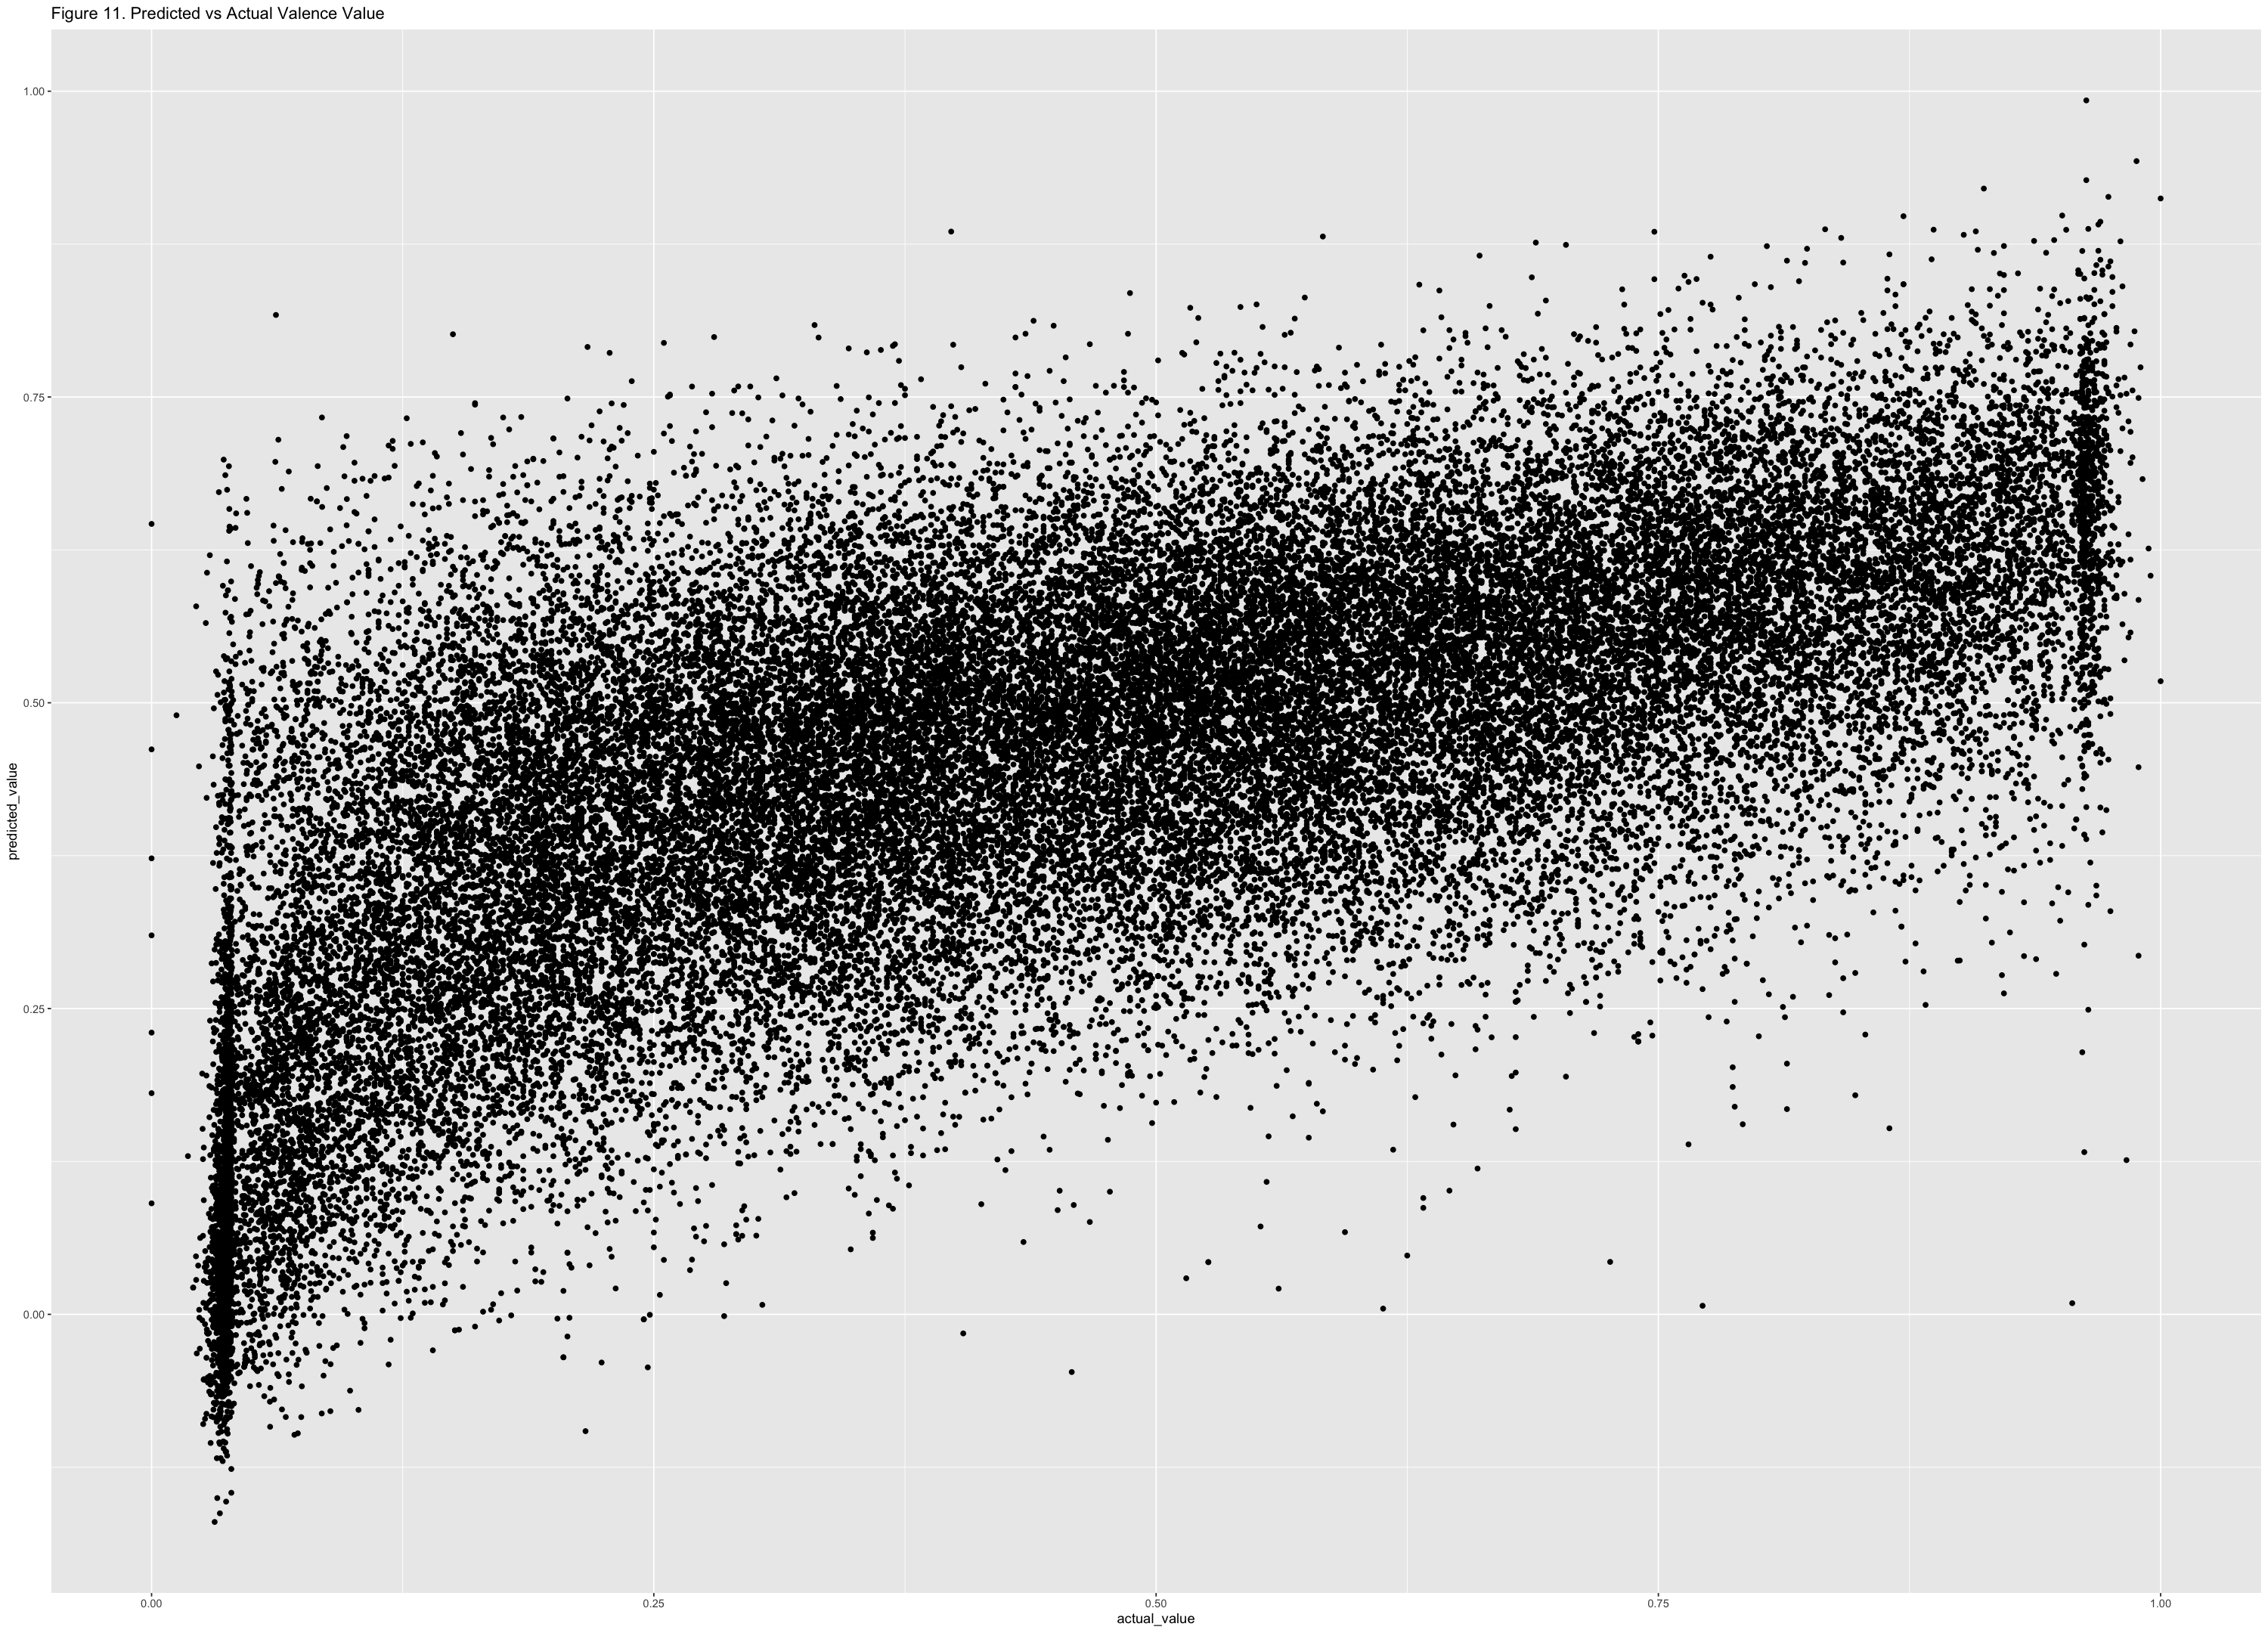

In [26]:
# Here, we get a vector of predicted values for our dataset using our model, 
predictions <- predict(spotify_model,
                       newdata = prediction_df %>% select(-valence) %>% data.frame())
pred_df <- tibble(
    predicted_value = predictions,
    actual_value = prediction_df$valence
)
print("Table 15: Predicted and Actual Values for Valence")
head(pred_df)
predictions_plot = pred_df %>%
    ggplot() +
    geom_point(aes(y = predicted_value, x = actual_value)) + 
    labs() +
    ggtitle("Figure 11. Predicted vs Actual Valence Value")
predictions_plot

Our model seems to loosely fit the data, with a similiar shape, however our model is not precise and seems to have high variation.

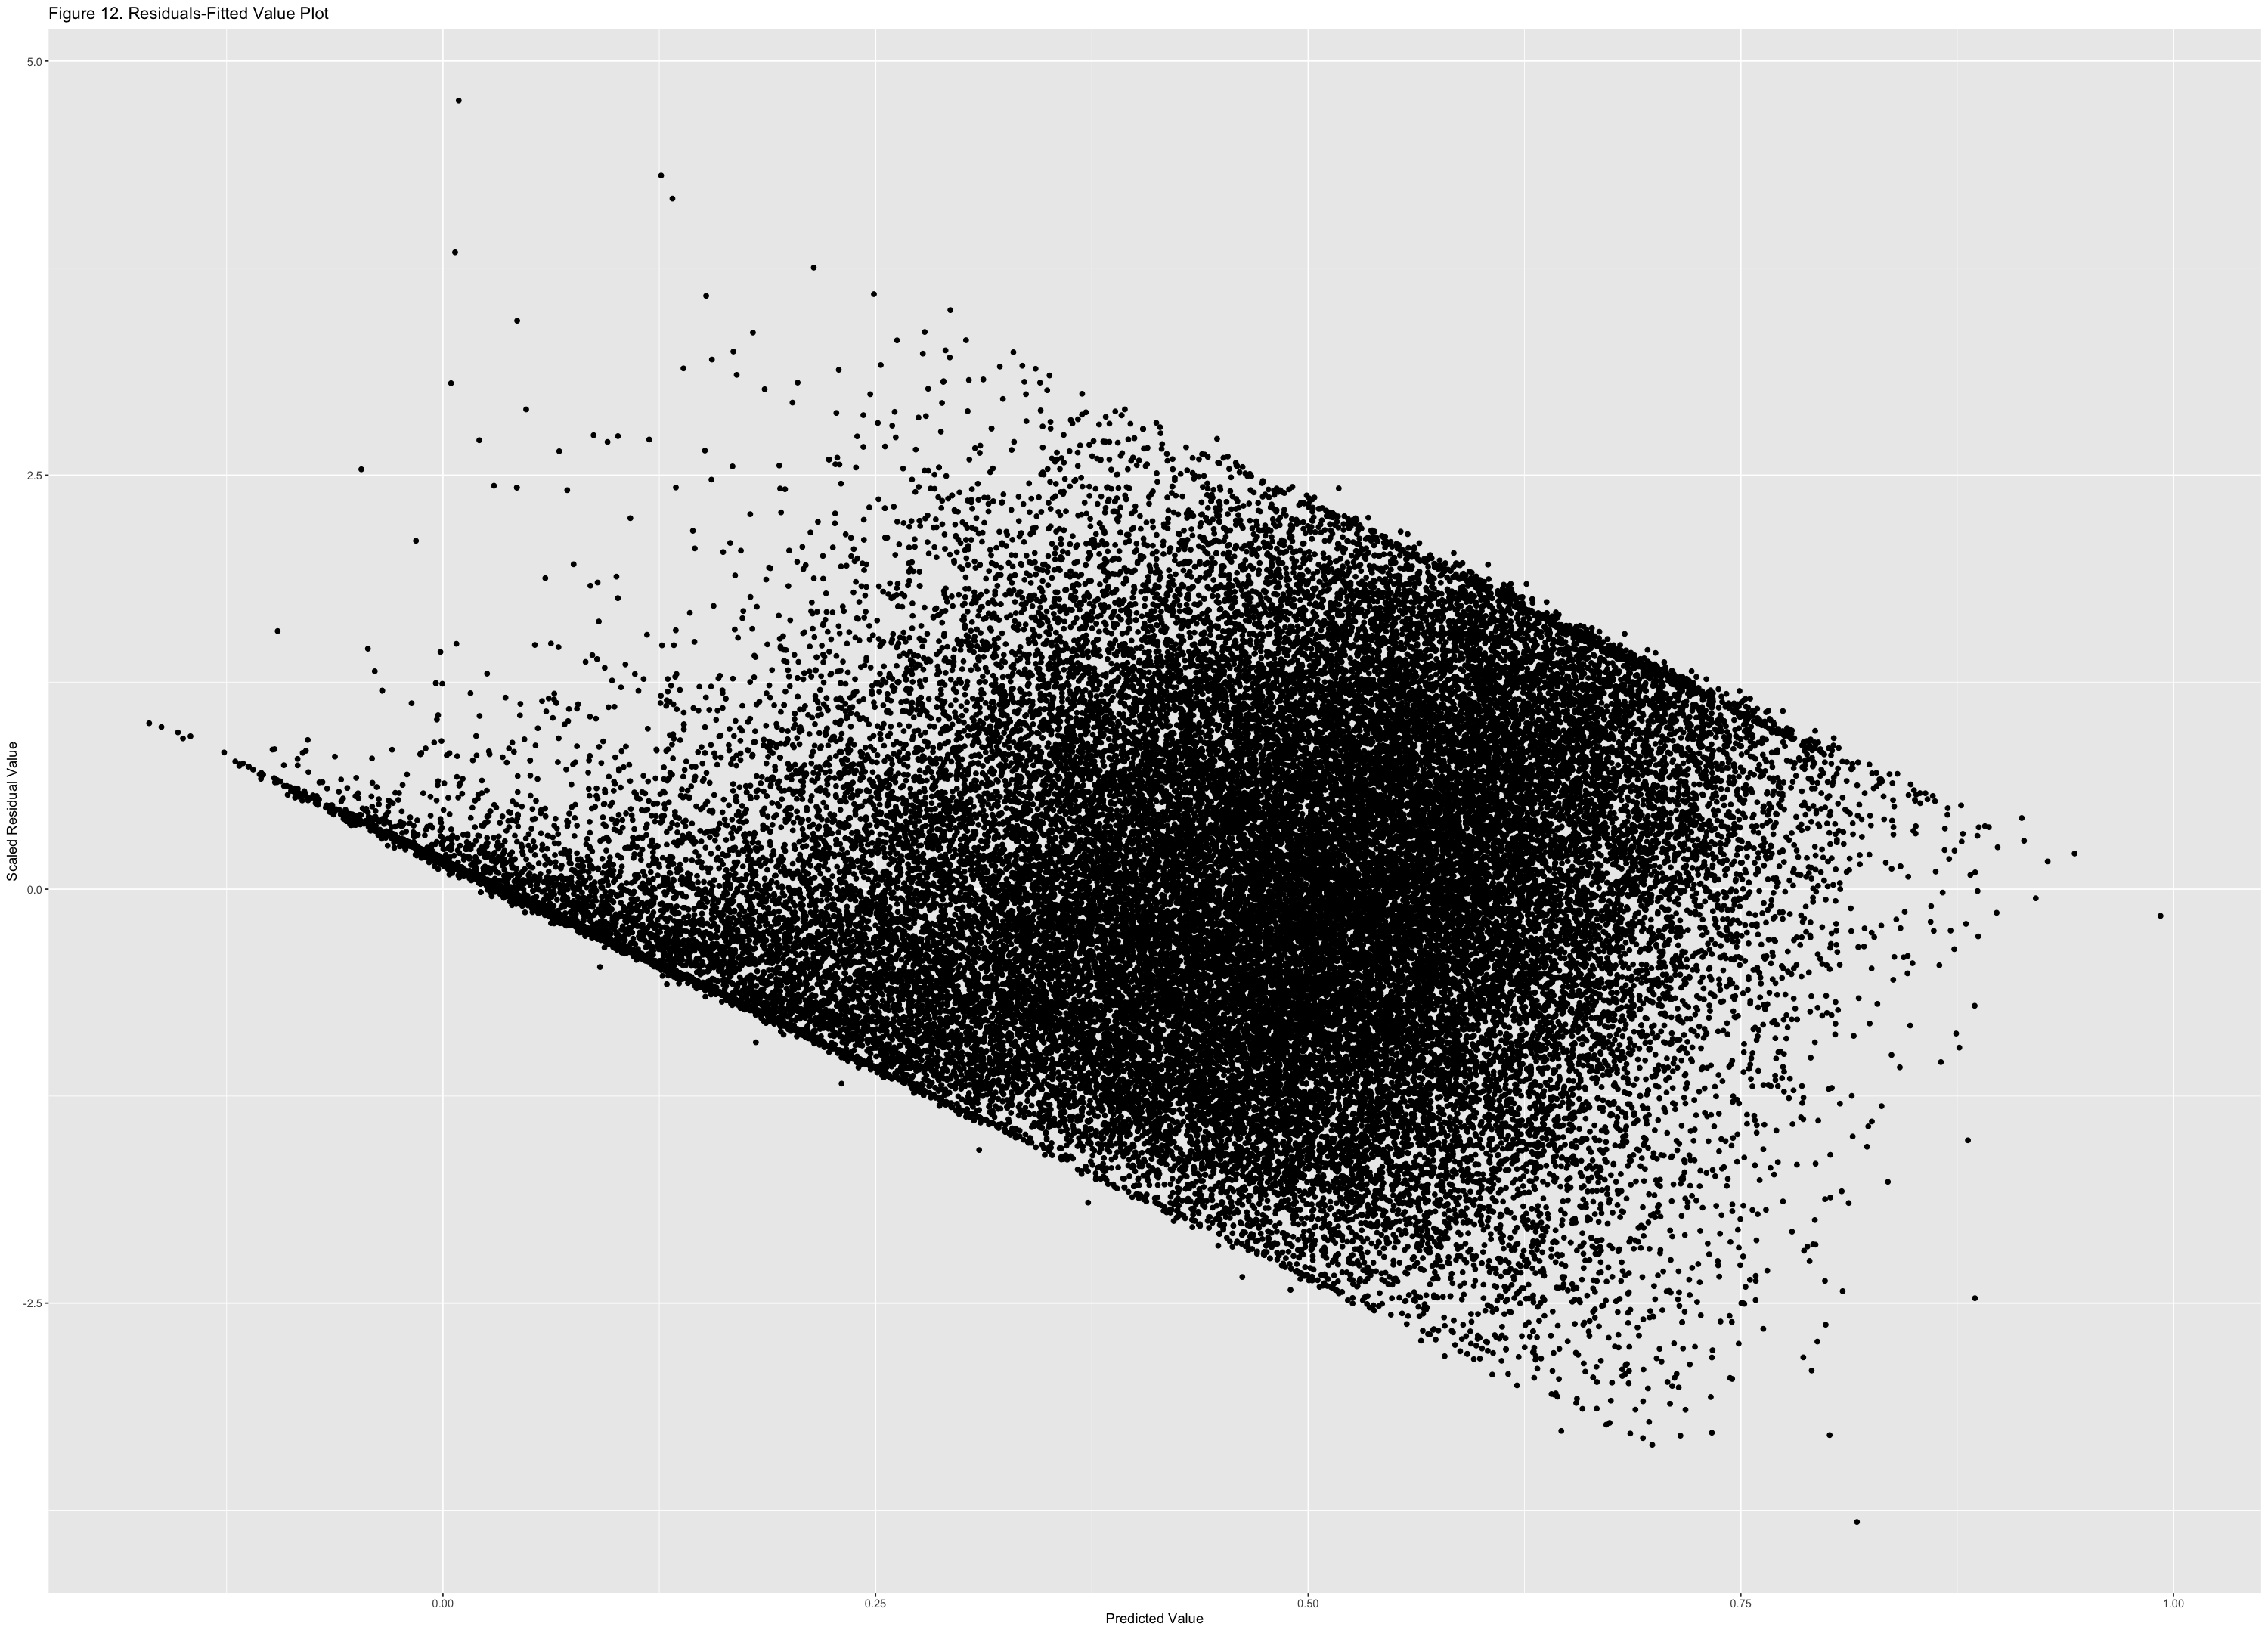

In [27]:
pred_df = pred_df %>%
          mutate(residual = scale((actual_value - predicted_value)))
residuals_plot = pred_df %>%
                 ggplot() +
                 geom_point(aes(x = predicted_value, y = residual)) + 
                 labs(title = "Figure 12. Residuals-Fitted Value Plot", y = "Scaled Residual Value", x = "Predicted Value")
residuals_plot

Our residual plot has a clear linear trend, indicating homoscedasticity, and seems there may be variables affecting valence that our model is not accounting for, which might be the categorical variables we filtered out. 

In [28]:
# Calculating the RMSE for our final model
inf_RMSE = R_MSE_models$R_MSE[2]
pred_RMSE = mean((pred_df$actual_value - pred_df$predicted_value)^2) %>% sqrt() 
cat("Training root mean squared error:", inf_RMSE, "\nTesting root mean squared error:", pred_RMSE)

Training root mean squared error: 0.1964715 
Testing root mean squared error: 0.1982908

Our inference RMSE (RMSE for the data we fit the model on) and prediction RMSE (for unknown data) are similiar, thus there is not any indication of overfitting or underfitting, and our model should generalize well.

## Discussion

### Findings
We determined that popularity, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness and tempo may contribute to a Spotify song’s emotional valence. This was not expected as we had thought that some variables may be irrelevant for our analysis, however all coefficients were returned as significant and neither greedy selection method nor the regularization methods LASSO and Ridge identified removable features (Table 6). We can interpret this as each feature may contribute to the valence value to some degree and thus a combination of these linear variables would be best suited for making predictions on new music.

To select our inference model, we first compared the full model to a nested one without the highly correlated variables, loudness and energy, to see if the data had problems with multicollinearity, as we found that the variance inflation factors (VIF) for those variables were greater than the others. Loudness, a psychological measure of physical strength (amplitude), does logically relate to energy, which represents a perceptual measure of intensity and activity within a track; thus, we may expect energetic tracks that feel fast and noisy to also be typically louder. However, our F-test confirmed that the full model was significantly better than the reduced and therefore, the inclusion of both factors seems to fit the data better. This choice is also supported by James et al. ‘'s method (2013) which states that only VIFs exceeding 5 or 10 should pose problems for multicollinearity.

We also compared the root mean squared error (RMSE) of the ordinary least squares (OLS) model to the LASSO and Ridge models to assess predictive performance, where the full OLS model returned the lowest error on unseen data (Table 13). We can interpret this as the full OLS generating coefficients that are less biased when compared to the other models, reducing the amount of overfitting on the training set. From our estimates, we also observe that with all other variables held constant, valence will increase by 0.707 for every increase by 1 in danceability and similarly decrease by 0.119 for every increase by 1 in speechiness on average (Table 7). As some variables are between 0 and 1, we can interpolate to calculate the effects on valence for decimal changes in these features.

With the OLS model, we used a portion of our sample to generate predictions for unseen Spotify songs. We obtained a RMSE of approximately 0.198, thus our test predictions were generally about 0.20 off compared to the actual valence values. In other words, since valence is measured between 0 and 1, this means our model estimates have roughly 20% error on average. As our prediction (test) error is only 0.003 different from the inference (train) error, our model seems to generalize well to new data. However, this degree of error is still fairly large; a song’s valence could be predicted between 0.30 and 0.70 when its actual value is 0.50, thus leading us to assume its positivity or negativity when it is in fact neutral. Despite this, our other models produced similar RMSEs (Table 13), indicating that this level of predictive performance may be expected given the input variables used.

### Strengths

Our sample should be representative of all songs on Spotify as we do not expect the range of our input variables to change drastically (e.g. outside the bounds of human hearing) nor should there be significant deviations in valence values from one year to another or between regions of the world. Moreover, since we tested our inference model on a separate subsample, we assume that our model will perform reasonably well on other unseen Spotify data.

### Impacts and Implications

We made the decision to exclude categorical variables due to limits in computational power, however we cannot say for certain that these factors may not impact the valence. It is possible that genre could still be confounding; for example, certain feature values could affect the valence differentially if a song is classical or reggae given their different distributions (Figure 1). We also determined from Figure 12 that the data appears to be homoscedastic but biased, hence we may be missing another input variable in our analysis that may explain the diagonal pattern of the residuals. While valence is scaled between 0 and 1, the distribution is not precisely normal (Figure 5). Similarly, some input variables were skewed (ex. instrumentalness, liveness, loudness and speechiness). Therefore, we may receive better results from logarithmically transforming the feature values to normalize them prior to training the linear models, though these methods were not discussed in STAT 301.

Since the method that Spotify uses to quantify valence remains unknown to the public, we hope that our results provide clarity on how humans perceive music. It seems that acousticness, danceability, energy and tempo contribute to making songs more cheerful, whereas popularity, instrumentalness, liveness, loudness and speechiness may be associated with more depressing music (Table 7). As our impressions appear to be based on a variety of components, it is unlikely that we can design tracks which emphasize certain features to produce the “happiest track ever” or vice versa. However, if you listen to music that is more energetic and loud, our analysis supports that you may prefer listening to positively valenced songs. From this assumption, it may be reasonable to make suggestions to Spotify users based on their most frequently played tracks’ feature values, though further human research would be required to confirm.

### Future Questions

- How does valence affect the popularity of Spotify tracks and their longevity to remain on the top of rankings charts?
- Given the identified key contributors to valence, can these be attributed to making songs more or less likeable? Can we predict whether someone will enjoy a song based on these features?
- Is Spotify suggesting new songs to users based on their valence? What ethical implications may this measure have on the emotions and/or mood of listeners?



## References

Baldwin, C. L., & Lewis, B. A. (2017). Positive valence music restores executive control over 
sustained attention. PLOS ONE, 12(11). https://doi.org/10.1371/journal.pone.0186231 

Business of Apps. (2021, October 29). Spotify revenue and Usage Statistics (2021). Business of Apps. 
Retrieved November 4, 2021, from https://www.businessofapps.com/data/spotify-statistics/. 

Hamidani, Z. (2019, July 23). Spotify tracks DB. Kaggle. Retrieved November 4, 2021, from 
https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db. 

Roy, M., Peretz, I., & Rainville, P. (2008). Emotional valence contributes to music-induced 
analgesia. Pain, 134(1), 140–147. https://doi.org/10.1016/j.pain.2007.04.003 

Tajadura-Jiménez, A., Pantelidou, G., Rebacz, P., Västfjäll, D., & Tsakiris, M. (2011). I-space: 
The effects of emotional valence and source of music on interpersonal distance. PLOS ONE, 
6(10). https://doi.org/10.1371/journal.pone.0026083 